<a href="https://colab.research.google.com/github/OrionXV/Volve-Well-Log-Prediction/blob/main/notebooks/GANaugment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Augmentation

Predictors used:

* Decsion Tree
* Gradient Booster
* Neural Network
* LSTM


In [1]:
!pip install lasio
!pip install md_toc
!pip install tensorflow
!pip install tensorflow-addons
!pip install smogn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools

import lasio

import glob
import os
import md_toc

from sklearn.svm import OneClassSVM

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from keras.optimizers import Adam

from keras import layers
from keras import models

import tensorflow as tf
from tqdm import tqdm

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Fetching Data

In [4]:
!git clone https://github.com/OrionXV/Volve-Well-Log-Prediction.git

fatal: destination path 'Volve-Well-Log-Prediction' already exists and is not an empty directory.


In [5]:
# Find paths to the log files (MS windows path style)
paths = sorted(glob.glob(os.path.join(os.getcwd(),"/content/Volve-Well-Log-Prediction/well_logs", "*.LAS")))

# Create a list for loop processing
log_list = [0] * len(paths)

# Parse LAS with LASIO to create pandas df
for i in range(len(paths)):
  df = lasio.read(paths[i])
  log_list[i] = df.df()
  # this transforms the depth from index to regular column
  log_list[i].reset_index(inplace=True)

log_list[0].head()

,DEPTH,ABDCQF01,ABDCQF02,ABDCQF03,ABDCQF04,BS,CALI,DRHO,DT,DTS,...,PEF,RACEHM,RACELM,RD,RHOB,RM,ROP,RPCEHM,RPCELM,RT
0,188.5,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,188.6,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,188.7,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,188.8,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,188.9,NaN,NaN,NaN,NaN,36.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Prepareing Data

In [6]:
# Save logs from list of dfs into separate variables
log1, log2, log3, log4, log5 = log_list
# Lists of depths for clipping
lower = [2600, 3200, 2620, 3100, 3100]
upper = [3720, 4740, 3640, 3400, 4050]

# Lists of selected columns
train_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']
test_cols = ['DEPTH', 'NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']

log_list_clipped = [0] * len(paths)

for i in range(len(log_list)):

  # Clip depths
  temp_df = log_list[i].loc[
      (log_list[i]['DEPTH'] >= lower[i]) &
      (log_list[i]['DEPTH'] <= upper[i])
  ]

  # Select train-log columns
  if i in [0,2,3]:
    log_list_clipped[i] = temp_df[train_cols]

  # Select test-log columns
  else:
    log_list_clipped[i] = temp_df[test_cols]

# Save logs from list into separate variables
log1, log2, log3, log4, log5 = log_list_clipped
# check for NaN
log1.head()

,DEPTH,NPHI,RHOB,GR,RT,PEF,CALI,DT
24115,2600.0,0.371,2.356,82.748,1.323,7.126,8.648,104.605
24116,2600.1,0.341,2.338,79.399,1.196,6.654,8.578,103.827
24117,2600.2,0.308,2.315,74.248,1.171,6.105,8.578,102.740
24118,2600.3,0.283,2.291,68.542,1.142,5.613,8.547,100.943
24119,2600.4,0.272,2.269,60.314,1.107,5.281,8.523,98.473


In [7]:
# Concatenate dataframes
train = pd.concat([log1, log3, log4])
pred = pd.concat([log2, log5])

# Assign names
names = ['15_9-F-11A', '15_9-F-11B', '15_9-F-1A', '15_9-F-1B', '15_9-F-1C']

names_train = []
names_pred = []

for i in range(len(log_list_clipped)):
  if i in [0,2,3]:
    # Train data, assign names
    names_train.append(np.full(len(log_list_clipped[i]), names[i]))
  else:
    # Test data, assign names
    names_pred.append(np.full(len(log_list_clipped[i]), names[i]))

# Concatenate inside list
names_train = list(itertools.chain.from_iterable(names_train))
names_pred = list(itertools.chain.from_iterable(names_pred))

# Add well name to df
train['WELL'] = names_train
pred['WELL'] = names_pred

# Pop and add depth to end of df
depth_train, depth_pred = train.pop('DEPTH'), pred.pop('DEPTH')
train['DEPTH'], pred['DEPTH'] = depth_train, depth_pred

# Train dataframe with logs 1,3,4 vertically stacked
train.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
24115,0.371,2.356,82.748,1.323,7.126,8.648,104.605,15_9-F-11A,2600.0
24116,0.341,2.338,79.399,1.196,6.654,8.578,103.827,15_9-F-11A,2600.1
24117,0.308,2.315,74.248,1.171,6.105,8.578,102.740,15_9-F-11A,2600.2
24118,0.283,2.291,68.542,1.142,5.613,8.547,100.943,15_9-F-11A,2600.3
24119,0.272,2.269,60.314,1.107,5.281,8.523,98.473,15_9-F-11A,2600.4


In [8]:
colnames = train.columns
only_feature = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI'] # only feature column names
only_target = 'DT' # only target column names
feature_target = np.append(only_feature, only_target) # feature and target column names

colnames

Index(['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT', 'WELL', 'DEPTH'], dtype='object')

## Data Transformation and Normalization

In [9]:
# Log transform the RT to logarithmic
train['RT'] = np.log10(train['RT'])

# Transformation / Normalizer object Yeo-Johnson method
scaler = PowerTransformer(method='yeo-johnson')

# ColumnTransformer (feature_target defines to which it is applied, leave Well and Depth untouched)
ct = ColumnTransformer([('transform', scaler, feature_target)], remainder='passthrough')

# Fit and transform
train_trans = ct.fit_transform(train)

# Convert to dataframe
train_trans = pd.DataFrame(train_trans, columns=colnames)
train_trans.head()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,WELL,DEPTH
0,1.702168,-0.920748,1.13065,-0.631876,0.031083,0.450019,1.58838,15_9-F-11A,2600.0
1,1.573404,-1.020621,1.092435,-0.736154,-0.373325,-1.070848,1.562349,15_9-F-11A,2600.1
2,1.407108,-1.142493,1.030314,-0.75808,-0.81989,-1.070848,1.525055,15_9-F-11A,2600.2
3,1.260691,-1.263078,0.956135,-0.784153,-1.197992,-1.753641,1.460934,15_9-F-11A,2600.3
4,1.189869,-1.367969,0.837247,-0.816586,-1.441155,-2.286222,1.367432,15_9-F-11A,2600.4


## Outlier Removal

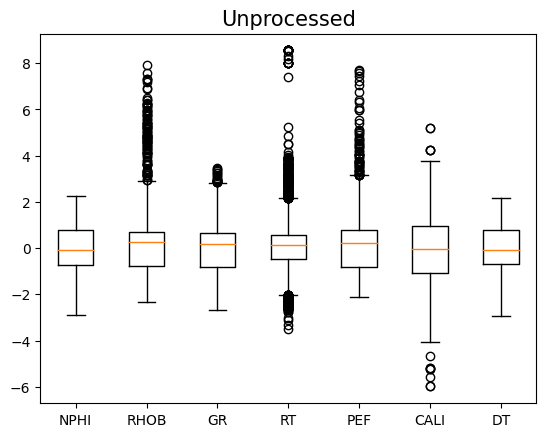

n samples unprocessed: 24403


In [10]:
# Make a copy of train
train_fonly = train_trans.copy()

# Remove WELL, DEPTH
train_fonly = train_fonly.drop(['WELL', 'DEPTH'], axis=1)
train_fonly_names = train_fonly.columns

# Helper function for repeated plotting

def makeboxplot(my_title='enter title',my_data=None):
    _, ax1 = plt.subplots()
    ax1.set_title(my_title, size=15)
    ax1.boxplot(my_data)
    ax1.set_xticklabels(train_fonly_names)
    plt.show()

makeboxplot('Unprocessed',train_trans[train_fonly_names])
print('n samples unprocessed:', len(train_fonly))

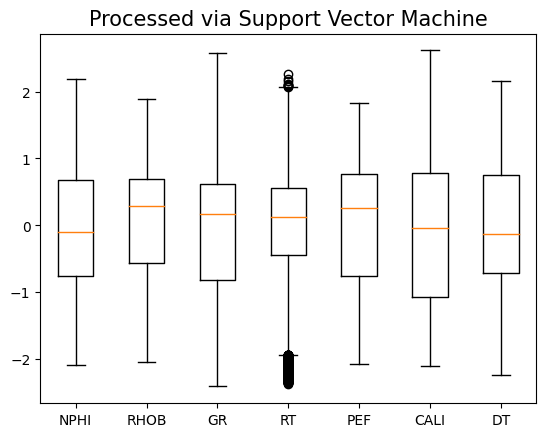

Remaining samples: 21964


In [11]:
svm = OneClassSVM(nu=0.1)
yhat = svm.fit_predict(train_fonly)
mask = yhat != -1
train_svm = train_fonly[mask]

makeboxplot('Processed via Support Vector Machine',train_svm)
print('Remaining samples:', len(train_svm))

In [12]:
feature_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI']
target_name = 'DT'


## Train and Validation Prep

In [13]:
# Select columns for features (X) and target (y)
X_train = train_svm[feature_names].values.astype('float32')
y_train = train_svm[target_name].values.reshape(-1, 1).astype('float32')

# Define the validation data
train_trans_copy = train_trans.copy()

train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

X_val = []
y_val = []

for i in range(len(train_well_names)):
    # Split the df by log name
    val = train_trans_copy.loc[train_trans_copy['WELL'] == train_well_names[i]].copy()

    # Drop name column
    val.drop(['WELL'], axis=1, inplace=True)

    # Define X_val (feature) and y_val (target) as NumPy arrays
    X_val_ = val[feature_names].values.astype('float32')
    y_val_ = val[target_name].values.reshape(-1, 1).astype('float32')

    X_val.append(X_val_)
    y_val.append(y_val_)

# Save into separate NumPy arrays
X_val1, X_val3, X_val4 = X_val
y_val1, y_val3, y_val4 = y_val

In [14]:
X_train = X_train.astype('float32')

# Cast y_train to float32
y_train = y_train.astype('float32')

# Cast X_val1, X_val3, X_val4 to float32
X_val1 = X_val1.astype('float32')
X_val3 = X_val3.astype('float32')
X_val4 = X_val4.astype('float32')

# Cast y_val1, y_val3, y_val4 to float32
y_val1 = y_val1.astype('float32')
y_val3 = y_val3.astype('float32')
y_val4 = y_val4.astype('float32')

# Data Augmentation

In [15]:
# Select columns for features (X) and target (y)
train_total = pd.merge(train_svm, train_trans, on = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT'], how='left')
train_gen = train_svm.copy()

In [16]:
train_well_names = ['15_9-F-11A', '15_9-F-1A', '15_9-F-1B']

df_gen1 = train_total[train_total['WELL'] == '15_9-F-11A'].copy()
df_gen3 = train_total[train_total['WELL'] == '15_9-F-1A'].copy()
df_gen4 = train_total[train_total['WELL'] == '15_9-F-1B'].copy()

In [17]:
# # Fit and transform the 'DEPTH' column for df_gen1
# df_gen1['DEPTH'] = scaler.fit_transform(df_gen1[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen3
# df_gen3['DEPTH'] = scaler.fit_transform(df_gen3[['DEPTH']])

# # Fit and transform the 'DEPTH' column for df_gen4
# df_gen4['DEPTH'] = scaler.fit_transform(df_gen4[['DEPTH']])

In [18]:
df_gen1.drop(columns = 'WELL').astype('float32').describe()

,NPHI,RHOB,GR,RT,PEF,CALI,DT,DEPTH
count,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000,10228.000000
mean,-0.112095,-0.003497,-0.274721,0.056440,0.292885,0.118036,-0.094888,3153.243408
std,0.992792,0.944150,0.921068,0.916372,0.998347,0.859239,1.046198,316.025391
min,-2.063082,-2.048020,-2.410065,-2.362914,-1.802307,-2.108308,-2.230961,2600.000000
25%,-0.881575,-0.800520,-0.988074,-0.233863,-0.365790,-0.046527,-0.872950,2888.974976
50%,-0.276245,0.320521,-0.268374,0.237194,0.713391,-0.046527,-0.341816,3152.949951
75%,0.719418,0.724360,0.373959,0.662223,1.113527,0.964887,0.827411,3420.825012
max,2.159336,1.725366,2.386178,2.267929,1.826932,2.615517,2.152846,3719.600098


In [19]:
# Define the GAN model architecture
def build_generator(latent_dim, num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(32, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(128, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(256, activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(num_features, activation='linear'))  # Output layer
    return model

def build_discriminator(num_features):
    model = models.Sequential()
    model.add(layers.Dense(256, input_shape=(num_features,), activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(32, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(64, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation=None))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer
    return model


In [20]:
generator_loss_fn =  tf.keras.losses.BinaryFocalCrossentropy()
discriminator_loss =  tf.keras.losses.BinaryFocalCrossentropy()


In [21]:
def train_gan(generator, discriminator, epochs, batch_size, data_frame, generator_optimizer, discriminator_optimizer):
    data_frame = data_frame

    # Determine the number of batches
    num_samples = len(data_frame)
    num_batches = num_samples // batch_size

    for epoch in range(epochs):
        avg_gen_loss = 0
        avg_disc_loss = 0
        with tqdm(total=num_batches, desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:

            for batch in range(num_batches):

                # Get real data for the current batch
                batch_start = batch * batch_size
                batch_end = (batch + 1) * batch_size
                real_data = data_frame.iloc[batch_start:batch_end]
                real_data = real_data.values.astype('float32')

                # Sample random noise for generator input
                noise = np.random.uniform(-1, 1, size=(len(real_data), latent_dim))

                # Generate synthetic data
                generated_data = generator.predict(noise,  verbose=0)

                # Combine real and generated data
                x_combined = np.concatenate([real_data, generated_data])

                # Labels for real and generated data
                y_real = np.ones((batch_size, 1))
                y_generated = np.zeros((batch_size, 1))
                y_combined = np.concatenate([y_real, y_generated])

                # Train discriminator
                with tf.GradientTape() as disc_tape:
                    # Forward pass: compute logits for real and fake samples
                    real_logits = discriminator(real_data, training=True)
                    fake_logits = discriminator(generated_data, training=True)

                    # Compute discriminator loss
                    real_labels = tf.ones_like(real_logits)
                    fake_labels = tf.zeros_like(fake_logits)
                    discriminator_loss_real = discriminator_loss(real_labels, real_logits)
                    discriminator_loss_fake = discriminator_loss(fake_labels, fake_logits)
                    discriminator_loss_total = (discriminator_loss_real + discriminator_loss_fake)

                # Compute gradients of discriminator loss with respect to discriminator trainable variables
                gradients_of_discriminator = disc_tape.gradient(discriminator_loss_total, discriminator.trainable_variables)

                # Update discriminator weights using optimizer
                discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

                with tf.GradientTape() as gen_tape:
                    # Generate fake samples using the generator
                    fake_samples = generator(noise, training=True)

                    # Compute generator loss
                    generator_loss = generator_loss_fn(real_labels, discriminator(fake_samples, training=True))

                # Compute gradients of generator loss with respect to generator trainable variables
                gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)

                # Update generator weights using optimizer
                generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

                avg_disc_loss += discriminator_loss_total
                avg_gen_loss +=  generator_loss

                pbar.update(1)

            # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Discriminator Loss: {avg_disc_loss/num_batches}, Generator Loss: {avg_gen_loss/num_batches}")


In [22]:
# Generate synthetic data for certain depths
def generate_synthetic_data(generator, num_samples):
    noise = np.random.uniform(-1, 1, size=(num_samples, latent_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data


In [24]:
# Train the GAN
# Define GAN components

latent_dim = 256

num_features = len(train_gen.columns)

generator_1 = build_generator(latent_dim, num_features)
discriminator_1 = build_discriminator(num_features)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

epochs = 64
batch_size = 4096
num_batches = len(train_gen) // batch_size
train_gan(generator_1, discriminator_1, epochs, batch_size, train_gen, generator_optimizer, discriminator_optimizer)

Epoch 1/64: 100%|██████████| 5/5 [00:09<00:00,  1.86s/batch]


Epoch 1/64, Discriminator Loss: 0.9220519065856934, Generator Loss: 0.39038288593292236


Epoch 2/64: 100%|██████████| 5/5 [00:02<00:00,  1.68batch/s]


Epoch 2/64, Discriminator Loss: 0.855932891368866, Generator Loss: 0.34910866618156433


Epoch 3/64: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 3/64, Discriminator Loss: 0.791873574256897, Generator Loss: 0.3191062808036804


Epoch 4/64: 100%|██████████| 5/5 [00:03<00:00,  1.59batch/s]


Epoch 4/64, Discriminator Loss: 0.7401097416877747, Generator Loss: 0.2975693345069885


Epoch 5/64: 100%|██████████| 5/5 [00:03<00:00,  1.31batch/s]


Epoch 5/64, Discriminator Loss: 0.7032313346862793, Generator Loss: 0.2846801280975342


Epoch 6/64: 100%|██████████| 5/5 [00:02<00:00,  1.73batch/s]


Epoch 6/64, Discriminator Loss: 0.6692807078361511, Generator Loss: 0.2742198705673218


Epoch 7/64: 100%|██████████| 5/5 [00:02<00:00,  1.68batch/s]


Epoch 7/64, Discriminator Loss: 0.643760621547699, Generator Loss: 0.263481080532074


Epoch 8/64: 100%|██████████| 5/5 [00:03<00:00,  1.34batch/s]


Epoch 8/64, Discriminator Loss: 0.624193012714386, Generator Loss: 0.25633591413497925


Epoch 9/64: 100%|██████████| 5/5 [00:03<00:00,  1.39batch/s]


Epoch 9/64, Discriminator Loss: 0.6048597097396851, Generator Loss: 0.25019964575767517


Epoch 10/64: 100%|██████████| 5/5 [00:03<00:00,  1.62batch/s]


Epoch 10/64, Discriminator Loss: 0.5872205495834351, Generator Loss: 0.24430572986602783


Epoch 11/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 11/64, Discriminator Loss: 0.571636974811554, Generator Loss: 0.23737087845802307


Epoch 12/64: 100%|██████████| 5/5 [00:03<00:00,  1.32batch/s]


Epoch 12/64, Discriminator Loss: 0.5578349232673645, Generator Loss: 0.23436179757118225


Epoch 13/64: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 13/64, Discriminator Loss: 0.5431936979293823, Generator Loss: 0.23126491904258728


Epoch 14/64: 100%|██████████| 5/5 [00:03<00:00,  1.66batch/s]


Epoch 14/64, Discriminator Loss: 0.5303595662117004, Generator Loss: 0.2271837294101715


Epoch 15/64: 100%|██████████| 5/5 [00:03<00:00,  1.58batch/s]


Epoch 15/64, Discriminator Loss: 0.5193975567817688, Generator Loss: 0.22278077900409698


Epoch 16/64: 100%|██████████| 5/5 [00:03<00:00,  1.41batch/s]


Epoch 16/64, Discriminator Loss: 0.5086697340011597, Generator Loss: 0.22044017910957336


Epoch 17/64: 100%|██████████| 5/5 [00:03<00:00,  1.61batch/s]


Epoch 17/64, Discriminator Loss: 0.49932748079299927, Generator Loss: 0.21747633814811707


Epoch 18/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 18/64, Discriminator Loss: 0.4908674359321594, Generator Loss: 0.21606914699077606


Epoch 19/64: 100%|██████████| 5/5 [00:04<00:00,  1.05batch/s]


Epoch 19/64, Discriminator Loss: 0.4837608337402344, Generator Loss: 0.2138628214597702


Epoch 20/64: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 20/64, Discriminator Loss: 0.4768264889717102, Generator Loss: 0.21182315051555634


Epoch 21/64: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 21/64, Discriminator Loss: 0.4709134101867676, Generator Loss: 0.20971707999706268


Epoch 22/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 22/64, Discriminator Loss: 0.4664338529109955, Generator Loss: 0.20785021781921387


Epoch 23/64: 100%|██████████| 5/5 [00:03<00:00,  1.28batch/s]


Epoch 23/64, Discriminator Loss: 0.4607856869697571, Generator Loss: 0.20663532614707947


Epoch 24/64: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 24/64, Discriminator Loss: 0.4571777284145355, Generator Loss: 0.20519904792308807


Epoch 25/64: 100%|██████████| 5/5 [00:02<00:00,  1.68batch/s]


Epoch 25/64, Discriminator Loss: 0.4523373246192932, Generator Loss: 0.20364336669445038


Epoch 26/64: 100%|██████████| 5/5 [00:03<00:00,  1.48batch/s]


Epoch 26/64, Discriminator Loss: 0.4489210247993469, Generator Loss: 0.20212146639823914


Epoch 27/64: 100%|██████████| 5/5 [00:03<00:00,  1.42batch/s]


Epoch 27/64, Discriminator Loss: 0.44498568773269653, Generator Loss: 0.2001502960920334


Epoch 28/64: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 28/64, Discriminator Loss: 0.4425431787967682, Generator Loss: 0.199306920170784


Epoch 29/64: 100%|██████████| 5/5 [00:02<00:00,  1.67batch/s]


Epoch 29/64, Discriminator Loss: 0.43953776359558105, Generator Loss: 0.19807854294776917


Epoch 30/64: 100%|██████████| 5/5 [00:03<00:00,  1.27batch/s]


Epoch 30/64, Discriminator Loss: 0.4369893968105316, Generator Loss: 0.1972227841615677


Epoch 31/64: 100%|██████████| 5/5 [00:03<00:00,  1.63batch/s]


Epoch 31/64, Discriminator Loss: 0.4341593384742737, Generator Loss: 0.19608135521411896


Epoch 32/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 32/64, Discriminator Loss: 0.43220338225364685, Generator Loss: 0.19528573751449585


Epoch 33/64: 100%|██████████| 5/5 [00:03<00:00,  1.63batch/s]


Epoch 33/64, Discriminator Loss: 0.4301794469356537, Generator Loss: 0.19413375854492188


Epoch 34/64: 100%|██████████| 5/5 [00:03<00:00,  1.31batch/s]


Epoch 34/64, Discriminator Loss: 0.42700815200805664, Generator Loss: 0.19348473846912384


Epoch 35/64: 100%|██████████| 5/5 [00:03<00:00,  1.63batch/s]


Epoch 35/64, Discriminator Loss: 0.4247138500213623, Generator Loss: 0.19246970117092133


Epoch 36/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 36/64, Discriminator Loss: 0.4223858416080475, Generator Loss: 0.19094473123550415


Epoch 37/64: 100%|██████████| 5/5 [00:03<00:00,  1.35batch/s]


Epoch 37/64, Discriminator Loss: 0.4204121232032776, Generator Loss: 0.1903524100780487


Epoch 38/64: 100%|██████████| 5/5 [00:03<00:00,  1.61batch/s]


Epoch 38/64, Discriminator Loss: 0.41931620240211487, Generator Loss: 0.1899755299091339


Epoch 39/64: 100%|██████████| 5/5 [00:02<00:00,  1.72batch/s]


Epoch 39/64, Discriminator Loss: 0.4168713092803955, Generator Loss: 0.18904267251491547


Epoch 40/64: 100%|██████████| 5/5 [00:03<00:00,  1.64batch/s]


Epoch 40/64, Discriminator Loss: 0.41504544019699097, Generator Loss: 0.18834619224071503


Epoch 41/64: 100%|██████████| 5/5 [00:03<00:00,  1.31batch/s]


Epoch 41/64, Discriminator Loss: 0.4141843914985657, Generator Loss: 0.18782633543014526


Epoch 42/64: 100%|██████████| 5/5 [00:04<00:00,  1.04batch/s]


Epoch 42/64, Discriminator Loss: 0.4125767648220062, Generator Loss: 0.18775156140327454


Epoch 43/64: 100%|██████████| 5/5 [00:02<00:00,  1.70batch/s]


Epoch 43/64, Discriminator Loss: 0.41071587800979614, Generator Loss: 0.1863776296377182


Epoch 44/64: 100%|██████████| 5/5 [00:03<00:00,  1.36batch/s]


Epoch 44/64, Discriminator Loss: 0.40960392355918884, Generator Loss: 0.18592236936092377


Epoch 45/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 45/64, Discriminator Loss: 0.40806421637535095, Generator Loss: 0.1855078935623169


Epoch 46/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 46/64, Discriminator Loss: 0.4069255292415619, Generator Loss: 0.18543565273284912


Epoch 47/64: 100%|██████████| 5/5 [00:02<00:00,  1.68batch/s]


Epoch 47/64, Discriminator Loss: 0.40604156255722046, Generator Loss: 0.18493559956550598


Epoch 48/64: 100%|██████████| 5/5 [00:03<00:00,  1.27batch/s]


Epoch 48/64, Discriminator Loss: 0.4042234420776367, Generator Loss: 0.18420974910259247


Epoch 49/64: 100%|██████████| 5/5 [00:02<00:00,  1.69batch/s]


Epoch 49/64, Discriminator Loss: 0.4032765328884125, Generator Loss: 0.18375548720359802


Epoch 50/64: 100%|██████████| 5/5 [00:03<00:00,  1.61batch/s]


Epoch 50/64, Discriminator Loss: 0.4028201997280121, Generator Loss: 0.18396945297718048


Epoch 51/64: 100%|██████████| 5/5 [00:03<00:00,  1.57batch/s]


Epoch 51/64, Discriminator Loss: 0.40141311287879944, Generator Loss: 0.18284684419631958


Epoch 52/64: 100%|██████████| 5/5 [00:03<00:00,  1.30batch/s]


Epoch 52/64, Discriminator Loss: 0.4003499448299408, Generator Loss: 0.18296238780021667


Epoch 53/64: 100%|██████████| 5/5 [00:03<00:00,  1.61batch/s]


Epoch 53/64, Discriminator Loss: 0.39961299300193787, Generator Loss: 0.18226875364780426


Epoch 54/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 54/64, Discriminator Loss: 0.3986584544181824, Generator Loss: 0.1820770800113678


Epoch 55/64: 100%|██████████| 5/5 [00:03<00:00,  1.34batch/s]


Epoch 55/64, Discriminator Loss: 0.39757364988327026, Generator Loss: 0.1815306693315506


Epoch 56/64: 100%|██████████| 5/5 [00:03<00:00,  1.61batch/s]


Epoch 56/64, Discriminator Loss: 0.3968542218208313, Generator Loss: 0.18125495314598083


Epoch 57/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 57/64, Discriminator Loss: 0.396146684885025, Generator Loss: 0.18111929297447205


Epoch 58/64: 100%|██████████| 5/5 [00:03<00:00,  1.65batch/s]


Epoch 58/64, Discriminator Loss: 0.3949783742427826, Generator Loss: 0.180801123380661


Epoch 59/64: 100%|██████████| 5/5 [00:03<00:00,  1.36batch/s]


Epoch 59/64, Discriminator Loss: 0.3946908712387085, Generator Loss: 0.18063774704933167


Epoch 60/64: 100%|██████████| 5/5 [00:03<00:00,  1.66batch/s]


Epoch 60/64, Discriminator Loss: 0.3935263752937317, Generator Loss: 0.18012464046478271


Epoch 61/64: 100%|██████████| 5/5 [00:03<00:00,  1.60batch/s]


Epoch 61/64, Discriminator Loss: 0.3927401006221771, Generator Loss: 0.18015894293785095


Epoch 62/64: 100%|██████████| 5/5 [00:03<00:00,  1.52batch/s]


Epoch 62/64, Discriminator Loss: 0.39227062463760376, Generator Loss: 0.1796570122241974


Epoch 63/64: 100%|██████████| 5/5 [00:04<00:00,  1.15batch/s]


Epoch 63/64, Discriminator Loss: 0.3917381167411804, Generator Loss: 0.1798231303691864


Epoch 64/64: 100%|██████████| 5/5 [00:03<00:00,  1.63batch/s]

Epoch 64/64, Discriminator Loss: 0.39062508940696716, Generator Loss: 0.17923471331596375


In [25]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_1 = generate_synthetic_data(generator_1, int(len(train)*0.15))

115/115 [==============================] - 0s 2ms/step


In [26]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_3 = generate_synthetic_data(generator_1, int(len(train)*0.15))

115/115 [==============================] - 0s 2ms/step


In [27]:
# Example usage: generate synthetic data for 100 samples
synthetic_data_4 = generate_synthetic_data(generator_1, int(len(train)*0.15))

115/115 [==============================] - 0s 2ms/step


In [28]:
columns = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT']

synthetic_df_1 = pd.DataFrame(synthetic_data_1, columns=columns)
synthetic_df_3 = pd.DataFrame(synthetic_data_3, columns=columns)
synthetic_df_4 = pd.DataFrame(synthetic_data_4, columns=columns)


In [29]:
from sklearn.ensemble import GradientBoostingRegressor
boosters = {}

# Train gradient boosters for each well
for well_name, df_gen in zip(train_well_names, [df_gen1, df_gen3, df_gen4]):
    # Filter data for the current well
    # df_gen = train_total[train_total['WELL'] == well_name].copy()

    # Define features (X) and target (y)
    X = df_gen.drop(columns=['DEPTH', 'WELL'])  # Assuming 'DEPTH' and 'WELL' are not features
    y = df_gen['DEPTH']

    # Train gradient booster
    booster = GradientBoostingRegressor()
    booster.fit(X, y)

    # Store trained booster in the dictionary
    boosters[well_name] = booster

# Use trained boosters to predict 'DEPTH' values for synthetic data frames
for synthetic_df, well_name in zip([synthetic_df_1, synthetic_df_3, synthetic_df_4], train_well_names):
    # Get corresponding booster for the well
    booster = boosters[well_name]

    # Predict 'DEPTH' values for synthetic data
    synthetic_df['DEPTH'] = booster.predict(synthetic_df)

In [30]:
# scaler.fit(train_total[train_total['WELL'] == '15_9-F-11A']['DEPTH'].values.reshape(-1, 1))
# df_gen1['DEPTH'] = scaler.inverse_transform(df_gen1['DEPTH'].values.reshape(-1, 1))
# synthetic_df_1['DEPTH'] = scaler.inverse_transform(synthetic_df_1['DEPTH'].values.reshape(-1, 1))

# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1A']['DEPTH'].values.reshape(-1, 1))
# df_gen3['DEPTH'] = scaler.inverse_transform(df_gen3['DEPTH'].values.reshape(-1, 1))
# synthetic_df_3['DEPTH'] = scaler.inverse_transform(synthetic_df_3['DEPTH'].values.reshape(-1, 1))


# scaler.fit(train_total[train_total['WELL'] == '15_9-F-1B']['DEPTH'].values.reshape(-1, 1))
# df_gen4['DEPTH'] = scaler.inverse_transform(df_gen4['DEPTH'].values.reshape(-1, 1))
# synthetic_df_4['DEPTH'] = scaler.inverse_transform(synthetic_df_4['DEPTH'].values.reshape(-1, 1))


In [31]:
def exponential_smoothing(series, alpha):
    smoothed_series = series.copy()
    for i in range(1, len(series)):
        smoothed_series[i] = alpha * series[i] + (1 - alpha) * smoothed_series[i - 1]
    return smoothed_series


In [32]:
# Define alpha for exponential smoothing (adjust as needed)
alpha = 0.2

# Apply sorting and exponential smoothing for each DataFrame
for synthetic_df in [synthetic_df_1, synthetic_df_3, synthetic_df_4]:
    synthetic_df.sort_values(by='DEPTH', inplace=True)
    for column in synthetic_df.columns:
        if column != 'WELL':  # Skip the 'WELL' column
            synthetic_df[column] = exponential_smoothing(synthetic_df[column], alpha)

In [33]:
synthetic_df_1['WELL'] = '15_9-F-11A'
synthetic_df_3['WELL'] = '15_9-F-1A'
synthetic_df_4['WELL'] = '15_9-F-1B'

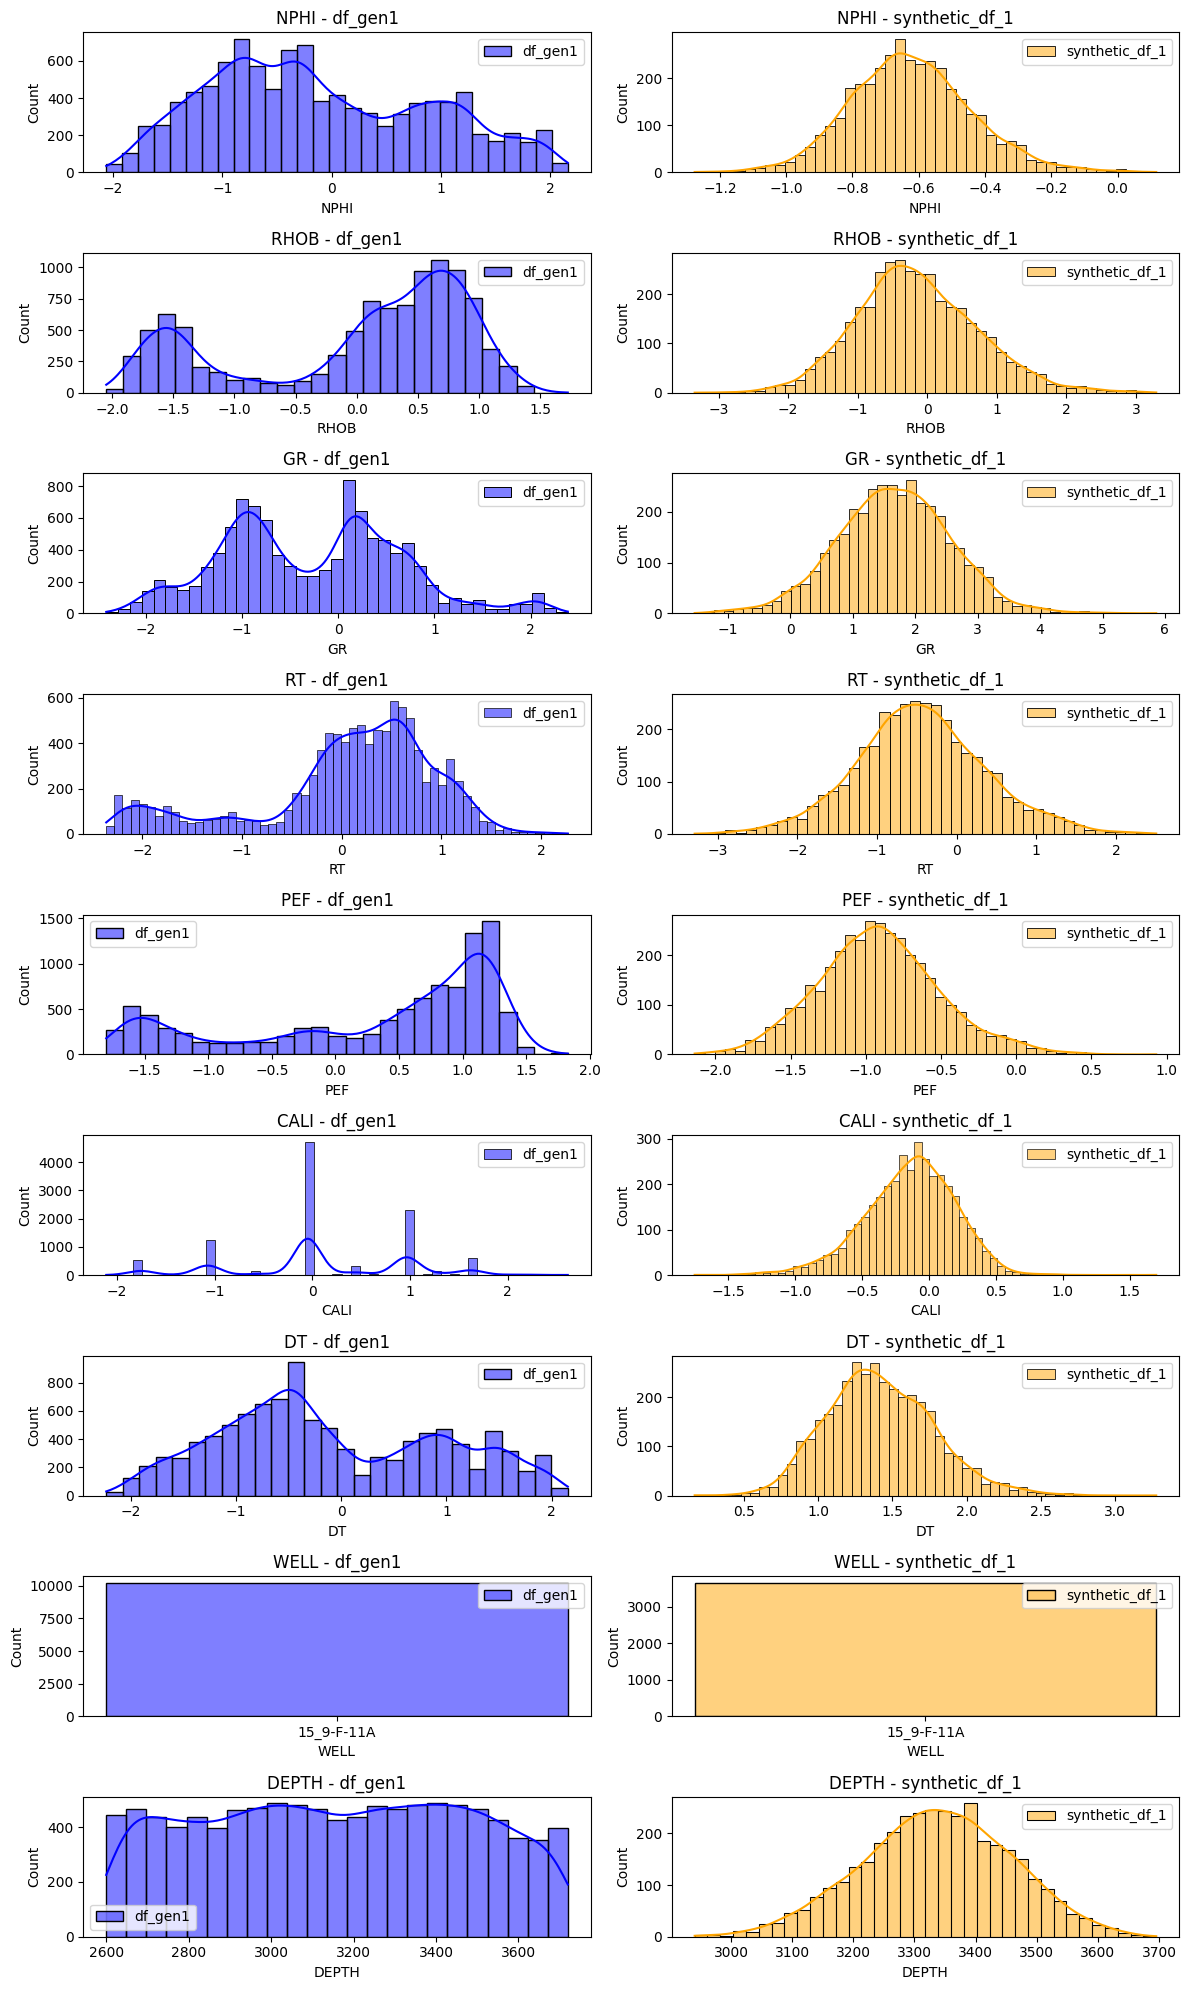

In [34]:
fig, axes = plt.subplots(nrows=len(df_gen1.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_1
for i, column in enumerate(df_gen1.columns):
    sns.histplot(df_gen1[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen1')
    axes[i, 0].set_title(f'{column} - df_gen1')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_1[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_1')
    axes[i, 1].set_title(f'{column} - synthetic_df_1')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

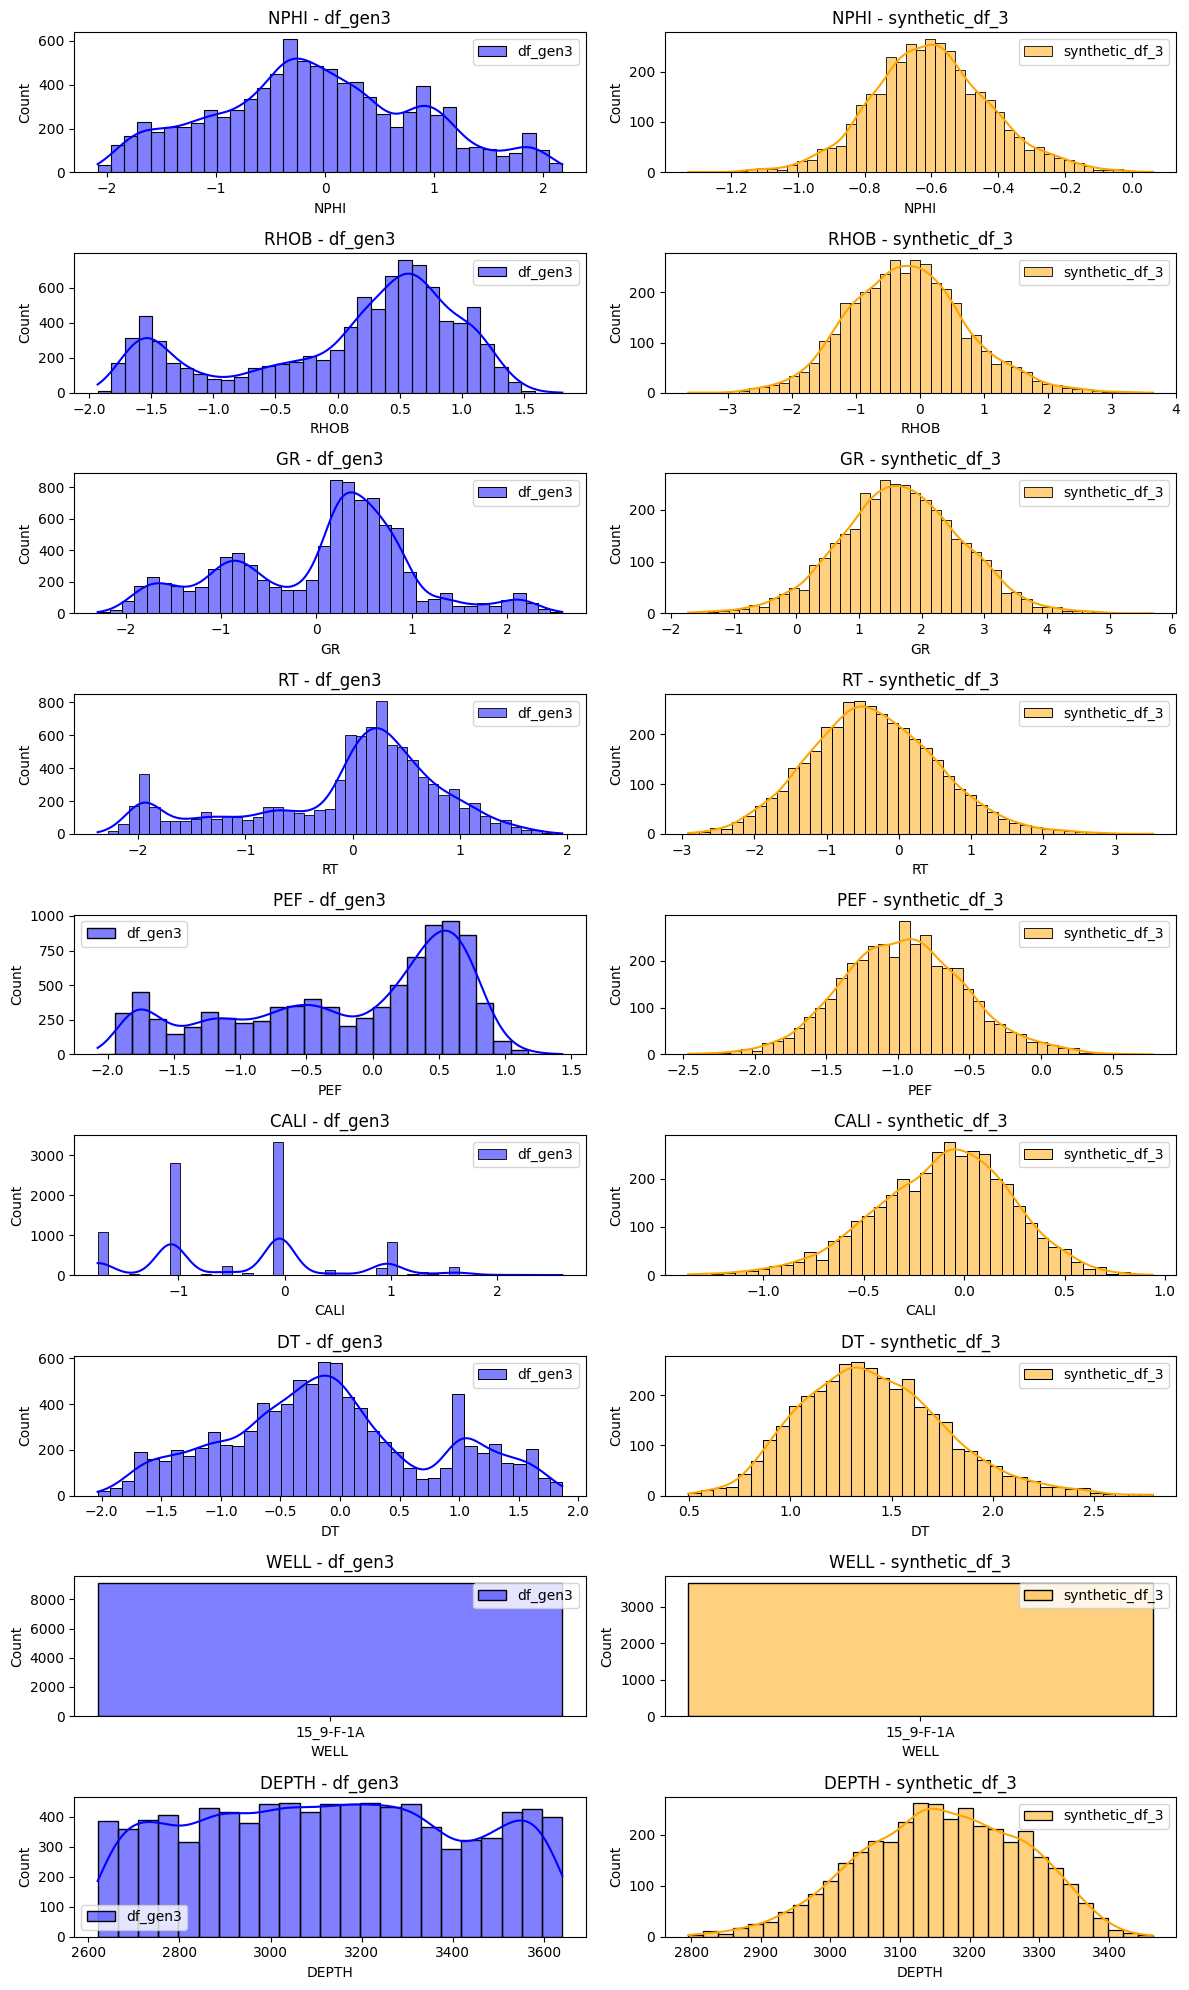

In [35]:
fig, axes = plt.subplots(nrows=len(df_gen3.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen3 and synthetic_df_3
for i, column in enumerate(df_gen3.columns):
    sns.histplot(df_gen3[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen3')
    axes[i, 0].set_title(f'{column} - df_gen3')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_3[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_3')
    axes[i, 1].set_title(f'{column} - synthetic_df_3')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

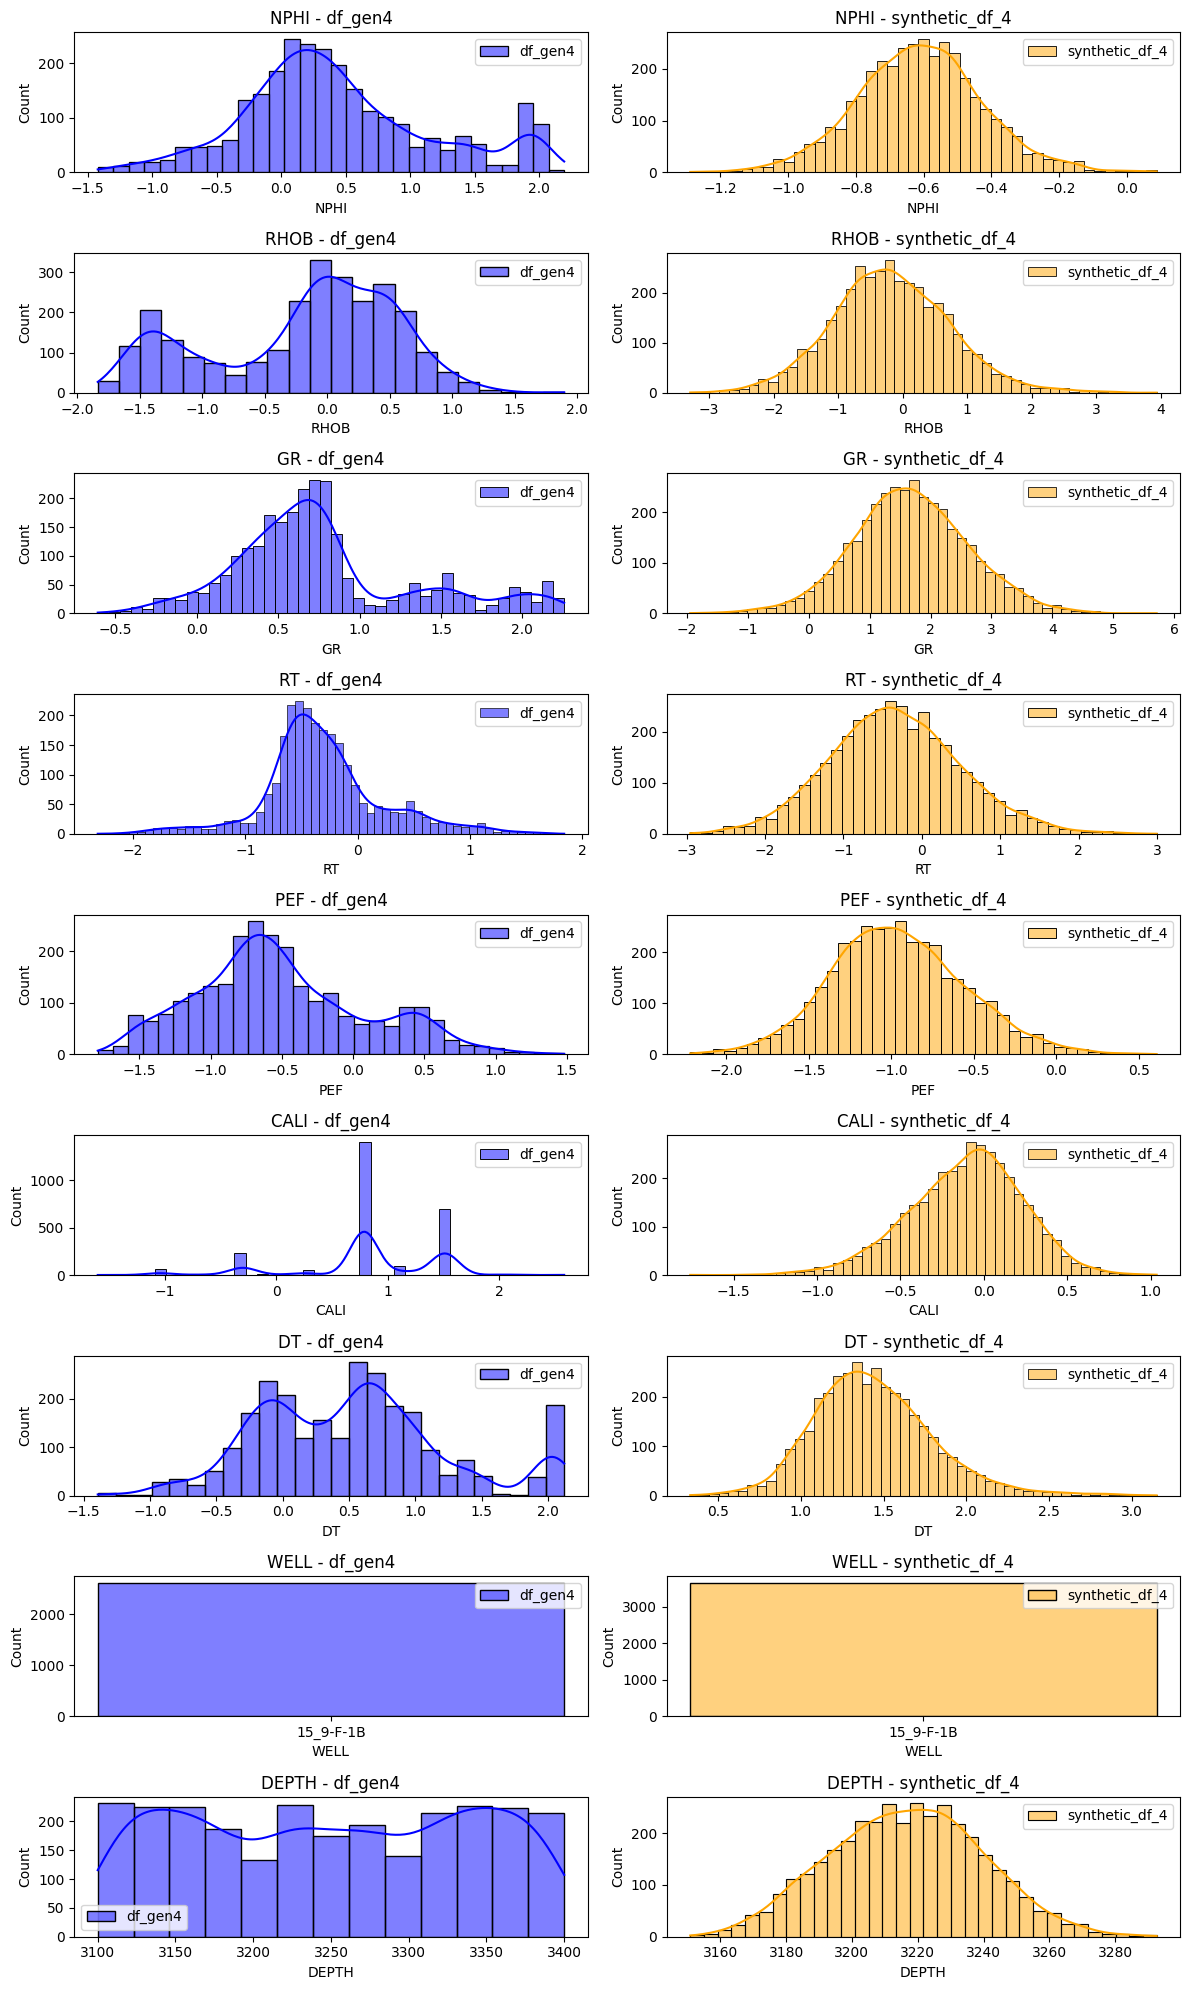

In [36]:
fig, axes = plt.subplots(nrows=len(df_gen4.columns), ncols=2, figsize=(12, 20))
fig.subplots_adjust(hspace=0.5)

# Plot histograms for each feature in df_gen1 and synthetic_df_4
for i, column in enumerate(df_gen4.columns):
    sns.histplot(df_gen4[column], ax=axes[i, 0], kde=True, color='blue', label='df_gen4')
    axes[i, 0].set_title(f'{column} - df_gen4')
    axes[i, 0].legend()

    sns.histplot(synthetic_df_4[column], ax=axes[i, 1], kde=True, color='orange', label='synthetic_df_4')
    axes[i, 1].set_title(f'{column} - synthetic_df_4')
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

In [37]:
df_gen1 = pd.concat([df_gen1, synthetic_df_1])
df_gen1 = df_gen1.sort_values(by='DEPTH')

df_gen3 = pd.concat([df_gen1, synthetic_df_3])
df_gen3  = df_gen3.sort_values(by='DEPTH')

df_gen4 = pd.concat([df_gen1, synthetic_df_4])
df_gen4 = df_gen4.sort_values(by='DEPTH')


In [38]:
X_train_new = pd.concat([df_gen1, df_gen3, df_gen4])
y_train_new = X_train_new['DT']
X_train_new.drop(['DT', 'WELL', 'DEPTH'], axis = 1, inplace= True)

y_train_new = y_train_new.values.reshape(-1,1).astype('float32')
X_train_new = X_train_new.values.astype('float32')

### Decison Tree Regressor


In [39]:
# Decision Tree Regressor object
model_decision_tree = DecisionTreeRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_decision_tree.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_decision_tree.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_decision_tree = model_decision_tree.predict(X_val1)
print("R2 Log 1: {}".format(round(model_decision_tree.score(X_val1, y_val1), 4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_decision_tree))
print("RMSE Log 1: {}".format(round(rmse, 4)))

# Validation: Predict on well 3
y_pred3_decision_tree = model_decision_tree.predict(X_val3)
print("R2 Log 3: {}".format(round(model_decision_tree.score(X_val3, y_val3), 4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_decision_tree))
print("RMSE Log 3: {}".format(round(rmse, 4)))

# Validation: Predict on well 4
y_pred4_decision_tree = model_decision_tree.predict(X_val4)
print("R2 Log 4: {}".format(round(model_decision_tree.score(X_val4, y_val4), 4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_decision_tree))
print("RMSE Log 4: {}".format(round(rmse, 4)))


RMSE for Fold 1: 0.2127
RMSE for Fold 2: 0.2113
RMSE for Fold 3: 0.2326
RMSE for Fold 4: 0.2075
RMSE for Fold 5: 0.2103
Average RMSE: 0.2149
R2 Log 1: 0.9744
RMSE Log 1: 0.1719
R2 Log 3: 0.9706
RMSE Log 3: 0.1585
R2 Log 4: 0.9478
RMSE Log 4: 0.1742


### Gradient Booster Regressor

In [40]:
# Gradient Booster object
model_grad_boost = GradientBoostingRegressor()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the regressor to the training fold
    model_grad_boost.fit(X_train_fold, y_train_fold)

    # Predict on the validation fold
    y_pred_fold = model_grad_boost.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_grad_boost = model_grad_boost.predict(X_val1)
print("R2 Log 1: {}".format(round(model_grad_boost.score(X_val1, y_val1),4)))
rmse = np.sqrt(mean_squared_error(y_val1, y_pred1_grad_boost))
print("RMSE Log 1: {}".format(round(rmse,4)))

# Validation: Predict on well 3
y_pred3_grad_boost = model_grad_boost.predict(X_val3)
print("R2 Log 3: {}".format(round(model_grad_boost.score(X_val3, y_val3),4)))
rmse = np.sqrt(mean_squared_error(y_val3, y_pred3_grad_boost))
print("RMSE Log 3: {}".format(round(rmse,4)))

# Validation: Predict on well 4
y_pred4_grad_boost = model_grad_boost.predict(X_val4)
print("R2 Log 4: {}".format(round(model_grad_boost.score(X_val4, y_val4),4)))
rmse = np.sqrt(mean_squared_error(y_val4, y_pred4_grad_boost))
print("RMSE Log 4: {}".format(round(rmse,4)))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 1: 0.2015


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 2: 0.2049


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 3: 0.2114


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 4: 0.1952


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE for Fold 5: 0.2092
Average RMSE: 0.2044
R2 Log 1: 0.9524
RMSE Log 1: 0.2344
R2 Log 3: 0.9413
RMSE Log 3: 0.2241
R2 Log 4: 0.9012
RMSE Log 4: 0.2395


### Neural Network

In [41]:
# Define the neural network model
def neural_network_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)  # Output layer
    ])
    return model

# Initialize and compile the neural network model
model_nn = neural_network_model(X_train_new.shape[1:])
model_nn.compile(optimizer='adam', loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Fit the neural network model to the training fold
    history_nn = model_nn.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_nn.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_nn = model_nn.predict(X_val1)
rmse_nn1 = np.sqrt(mean_squared_error(y_val1, y_pred1_nn))
print("RMSE Neural Network Log 1: {}".format(round(rmse_nn1, 4)))

# Validation: Predict on well 3
y_pred3_nn = model_nn.predict(X_val3)
rmse_nn3 = np.sqrt(mean_squared_error(y_val3, y_pred3_nn))
print("RMSE Neural Network Log 3: {}".format(round(rmse_nn3, 4)))

# Validation: Predict on well 4
y_pred4_nn = model_nn.predict(X_val4)
rmse_nn4 = np.sqrt(mean_squared_error(y_val4, y_pred4_nn))
print("RMSE Neural Network Log 4: {}".format(round(rmse_nn4, 4)))


138/138 [==============================] - 0s 2ms/step
RMSE for Fold 1: 0.1978
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 2: 0.1935
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 3: 0.1960
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 4: 0.1784
138/138 [==============================] - 0s 2ms/step
RMSE for Fold 5: 0.1835
Average RMSE: 0.1898
351/351 [==============================] - 1s 2ms/step
RMSE Neural Network Log 1: 0.25929999351501465
319/319 [==============================] - 1s 2ms/step
RMSE Neural Network Log 3: 0.21699999272823334
94/94 [==============================] - 0s 2ms/step
RMSE Neural Network Log 4: 0.24549999833106995


### LSTM

In [42]:
# Preparing data for LSTM
time_steps = 10

def prep_for_lstm(X_in, y_in, time_steps = 10):
    X_lstm = []
    y_lstm = []
    for i in range(len(X_in) - time_steps):
        X_lstm.append(X_in[i:i+time_steps])
        y_lstm.append(y_in[i+time_steps])

    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)
    return X_lstm, y_lstm

X_train_lstm, y_train_lstm = prep_for_lstm(X_train_new, y_train_new, time_steps = time_steps)
X_val1_lstm, y_val1_lstm = prep_for_lstm(X_val1, y_val1, time_steps = time_steps)
X_val3_lstm, y_val3_lstm = prep_for_lstm(X_val3, y_val3, time_steps = time_steps)
X_val4_lstm, y_val4_lstm = prep_for_lstm(X_val4, y_val4, time_steps = time_steps)


In [43]:
y_train_lstm.shape

(48974, 1)

In [44]:
# Define bidirectional LSTM model with three layers
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(units=64)))
model_lstm.add(Dense(units=1))  # Output layer
model_lstm.compile(optimizer=Adam(), loss='mean_squared_error')

# Initialize KFold with number of splits
kf = KFold(n_splits=5)

# Lists to store RMSE scores for each fold
rmse_scores = []

# Perform K-fold cross-validation training and prediction
for i, (train_index, val_index) in enumerate(kf.split(X_train_lstm)):
    X_train_fold, X_val_fold = X_train_lstm[train_index], X_train_lstm[val_index]
    y_train_fold, y_val_fold = y_train_lstm[train_index], y_train_lstm[val_index]


    # Fit the bidirectional LSTM model to the training fold
    history = model_lstm.fit(X_train_fold, y_train_fold, epochs=16, batch_size=1024, validation_data=(X_val_fold, y_val_fold), verbose=0)

    # Predict on the validation fold
    y_pred_fold = model_lstm.predict(X_val_fold)

    # Calculate RMSE for the fold
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

    # Print RMSE score for the fold
    print("RMSE for Fold {}: {:.4f}".format(i+1, rmse_fold))

# Calculate and print the average RMSE
avg_rmse = np.mean(rmse_scores)
print("Average RMSE: {:.4f}".format(avg_rmse))

# Validation: Predict on well 1
y_pred1_lstm = model_lstm.predict(X_val1_lstm)
rmse_lstm1 = np.sqrt(mean_squared_error(y_val1_lstm, y_pred1_lstm))
print("RMSE LSTM Log 1: {}".format(round(rmse_lstm1, 4)))

# Validation: Predict on well 3
y_pred3_lstm = model_lstm.predict(X_val3_lstm)
rmse_lstm3 = np.sqrt(mean_squared_error(y_val3_lstm, y_pred3_lstm))
print("RMSE LSTM Log 3: {}".format(round(rmse_lstm3, 4)))

# Validation: Predict on well 4
y_pred4_lstm = model_lstm.predict(X_val4_lstm)
rmse_lstm4 = np.sqrt(mean_squared_error(y_val4_lstm, y_pred4_lstm))
print("RMSE LSTM Log 4: {}".format(round(rmse_lstm4, 4)))


307/307 [==============================] - 3s 5ms/step
RMSE for Fold 1: 0.9326
307/307 [==============================] - 1s 5ms/step
RMSE for Fold 2: 0.8544
307/307 [==============================] - 2s 5ms/step
RMSE for Fold 3: 1.0919
307/307 [==============================] - 1s 5ms/step
RMSE for Fold 4: 0.6885
307/307 [==============================] - 1s 5ms/step
RMSE for Fold 5: 0.5317
Average RMSE: 0.8198
350/350 [==============================] - 2s 5ms/step
RMSE LSTM Log 1: 0.717199981212616
319/319 [==============================] - 2s 5ms/step
RMSE LSTM Log 3: 0.8967000246047974
94/94 [==============================] - 0s 5ms/step
RMSE LSTM Log 4: 0.7764000296592712


### Formatting back the predictions

In [45]:
# Make the transformer fit to the target
y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform  y_val, y_pred
y_val1 = scaler.inverse_transform(y_val1.reshape(-1,1))
y_val3 = scaler.inverse_transform(y_val3.reshape(-1,1))
y_val4 = scaler.inverse_transform(y_val4.reshape(-1,1))


# Define a list to hold all predictions
all_predictions = [y_pred1_grad_boost, y_pred3_grad_boost, y_pred4_grad_boost,
                   y_pred1_nn, y_pred3_nn, y_pred4_nn,
                   y_pred1_lstm, y_pred3_lstm, y_pred4_lstm,
                   y_pred1_decision_tree, y_pred3_decision_tree, y_pred4_decision_tree
                   ]

# Inverse transform all predictions
all_predictions_inverse = [scaler.inverse_transform(pred.reshape(-1, 1)) for pred in all_predictions]

# Split the transformed predictions back into separate variables
(
    y_pred1_grad_boost_inv,  y_pred3_grad_boost_inv, y_pred4_grad_boost_inv,
    y_pred1_nn_inv, y_pred3_nn_inv, y_pred4_nn_inv,
    y_pred1_lstm_inv, y_pred3_lstm_inv, y_pred4_lstm_inv,
    y_pred1_decision_tree_inv, y_pred3_decision_tree_inv, y_pred4_decision_tree_inv
) = all_predictions_inverse

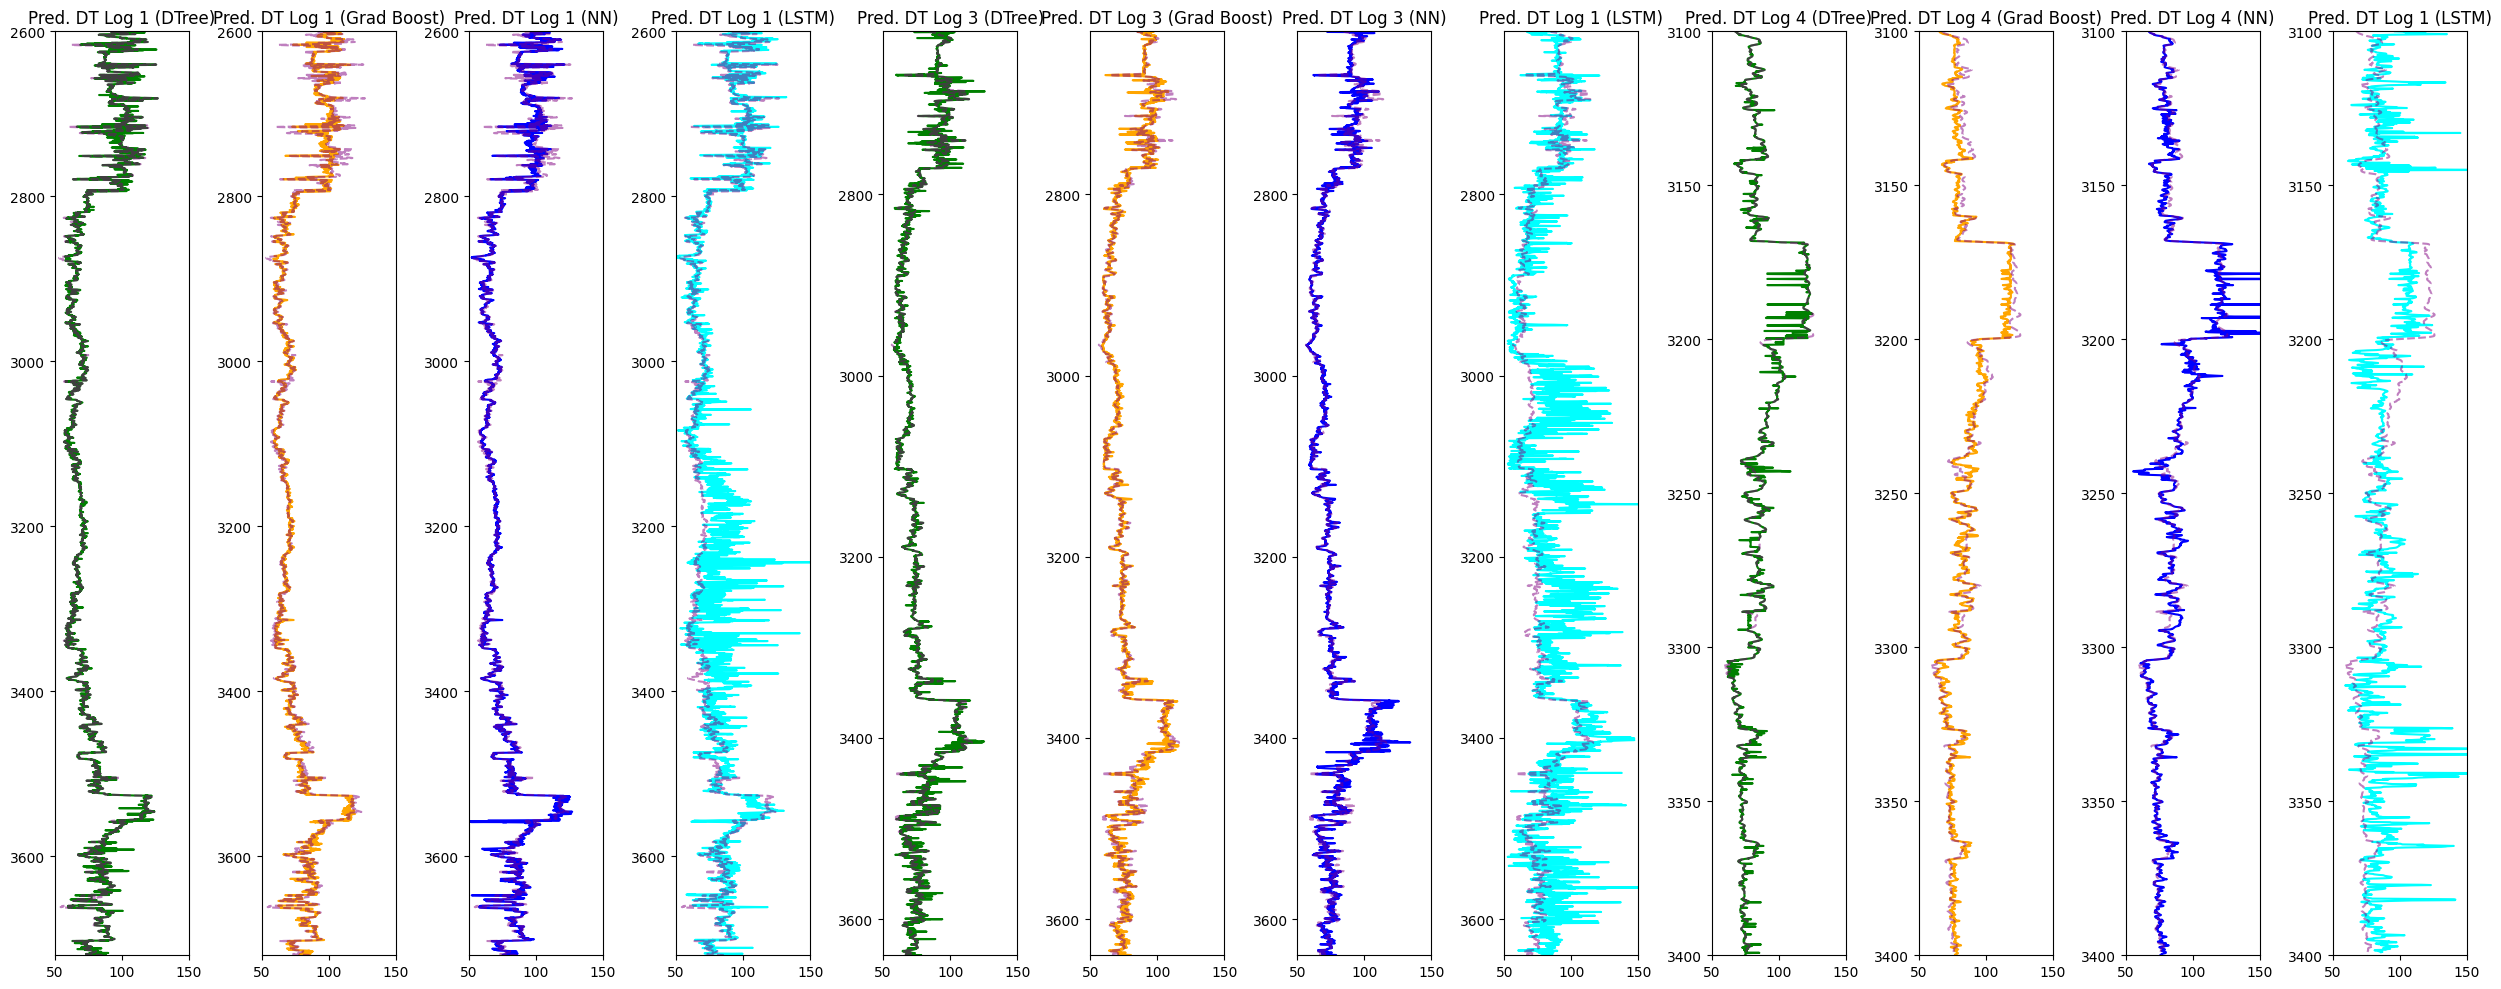

In [46]:
x_plott = [y_pred1_decision_tree_inv, y_pred1_grad_boost_inv, y_pred1_nn_inv,  y_pred1_lstm_inv,
           y_pred3_decision_tree_inv, y_pred3_grad_boost_inv, y_pred3_nn_inv,  y_pred3_lstm_inv,
           y_pred4_decision_tree_inv, y_pred4_grad_boost_inv, y_pred4_nn_inv,  y_pred4_lstm_inv]

x_real_plott = [
    y_val1,
    y_val3,
    y_val4
]

x_real_plott_lstm = [
    y_val1_lstm,
    y_val3_lstm,
    y_val4_lstm
]

y_plott = [log1['DEPTH'],
           log3['DEPTH'],
           log4['DEPTH']]

color_preds = ['green', 'orange', 'blue', 'cyan'] * 3
title_preds = ['Pred. DT Log 1 (DTree)', 'Pred. DT Log 1 (Grad Boost)', 'Pred. DT Log 1 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 3 (DTree)', 'Pred. DT Log 3 (Grad Boost)', 'Pred. DT Log 3 (NN)',  'Pred. DT Log 1 (LSTM)',
               'Pred. DT Log 4 (DTree)', 'Pred. DT Log 4 (Grad Boost)', 'Pred. DT Log 4 (NN)',  'Pred. DT Log 1 (LSTM)',]

fig, ax = plt.subplots(nrows=1, ncols=12, figsize=(25, 10))

for i, (x_pred, title) in enumerate(zip(x_plott, title_preds)):
    # Reshape y[i] to match the shape of x_pred
    y_i_reshaped = y_plott[i//4]
    ax[i].plot(x_pred, y_i_reshaped[:len(x_pred)], color=color_preds[i])
    ax[i].plot(x_real_plott[i//4], y_i_reshaped, color='purple', linestyle='dashed', alpha = 0.5) #if i%4 != 0 else x_real_plott_lstm[i//4]
    ax[i].set_xlim(50, 150)
    ax[i].set_ylim(max(y_i_reshaped), min(y_i_reshaped))  # Ensure correct order of y-axis
    ax[i].set_title(title)

plt.tight_layout()
plt.show()


In [47]:
# Define the test data
names_test = ['15_9-F-11B', '15_9-F-1C']

X_test = []
y_test = []
depths = []

for i in range(len(names_test)):
  # split the df with respect to its name
  test = pred.loc[pred['WELL'] == names_test[i]]

  # Drop well name column
  test = test.drop(['WELL'], axis=1)

  # Define X_test (feature)
  X_test_ = test[feature_names].values

  # Define depth
  depth_ = test['DEPTH'].values

  X_test.append(X_test_)
  depths.append(depth_)

# For each well 2 and 5
X_test2, X_test5 = X_test
depth2, depth5 = depths

In [48]:
X_test2

array([[ 0.075,  2.605,  9.348,  8.331,  7.451,  8.547],
       [ 0.077,  2.602,  9.362,  8.289,  7.464,  8.547],
       [ 0.078,  2.599,  9.545,  8.247,  7.405,  8.547],
       ...,
       [ 0.103,  2.592, 32.217,  4.232,  4.729,  8.734],
       [ 0.108,  2.583, 29.841,  4.233,  4.705,  8.75 ],
       [ 0.114,  2.571, 31.423,  4.225,  4.617,  8.76 ]])

In [49]:
# Transform X_test of log 2 and 5
X_test2 = scaler.fit_transform(X_test2)
X_test5 = scaler.fit_transform(X_test5)

X_test2_lstm, _ = prep_for_lstm(X_test2, X_test2, time_steps = time_steps)
X_test5_lstm, _ = prep_for_lstm(X_test5, X_test5, time_steps = time_steps)


# Predictions for log 2 using all models
y_pred2_grad_boost = model_grad_boost.predict(X_test2)
y_pred2_decision_tree = model_decision_tree.predict(X_test2)
y_pred2_nn = model_nn.predict(X_test2)
y_pred2_lstm = model_lstm.predict(X_test2_lstm)
#y_pred2_transformer = model_transformer.predict(X_test2)

# Predictions for log 5 using all models
y_pred5_grad_boost = model_grad_boost.predict(X_test5)
y_pred5_decision_tree = model_decision_tree.predict(X_test5)
y_pred5_nn = model_nn.predict(X_test5)
y_pred5_lstm = model_lstm.predict(X_test5_lstm)
#y_pred5_transformer = model_transformer.predict(X_test5)

y = train[target_name].values
scaler.fit(y.reshape(-1,1))

# Inverse transform y_pred for log 2
y_pred2_grad_boost = scaler.inverse_transform(y_pred2_grad_boost.reshape(-1,1))
y_pred2_decision_tree = scaler.inverse_transform(y_pred2_decision_tree.reshape(-1,1))
y_pred2_nn = scaler.inverse_transform(y_pred2_nn.reshape(-1,1))
y_pred2_lstm = scaler.inverse_transform(y_pred2_lstm.reshape(-1,1))
#y_pred2_transformer = scaler.inverse_transform(y_pred2_transformer.reshape(-1,1))

# Inverse transform y_pred for log 5
y_pred5_grad_boost = scaler.inverse_transform(y_pred5_grad_boost.reshape(-1,1))
y_pred5_decision_tree = scaler.inverse_transform(y_pred5_decision_tree.reshape(-1,1))
y_pred5_nn = scaler.inverse_transform(y_pred5_nn.reshape(-1,1))
y_pred5_lstm = scaler.inverse_transform(y_pred5_lstm.reshape(-1,1))
#y_pred5_transformer = scaler.inverse_transform(y_pred5_transformer.reshape(-1,1))


297/297 [==============================] - 1s 5ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


In [50]:
def pad_predicted_values(predicted_values, target_column, window_size=10):
    """
    Pad the predicted values using a moving average to fill in the gaps.

    Parameters:
        predicted_values (np.ndarray): The predicted values to pad.
        target_column (pd.Series): The target column used to calculate moving average.
        window_size (int): The size of the moving average window.

    Returns:
        np.ndarray: The padded predicted values.
    """
    # Calculate the number of values to pad
    pad_length = len(target_column) - len(predicted_values)

    # Pad the predicted values with NaNs to match the length of target_column
    padding = np.full((pad_length, 1), np.nan)

    padded_values = np.concatenate((padding, predicted_values))

    for i in range(len(padded_values)-1, -1, -1):
        if np.isnan(padded_values[i][0]):
            padded_values[i][0] = np.mean(padded_values[i+1:i+1+window_size])



    return padded_values


In [51]:
y_pred2_lstm

array([[63.61406 ],
       [64.21993 ],
       [65.778336],
       ...,
       [71.557495],
       [67.585365],
       [71.94938 ]], dtype=float32)

In [52]:
pad_predicted_values(y_pred2_lstm, y_pred2_nn)

array([[67.60825664],
       [67.30022718],
       [67.1618734 ],
       ...,
       [71.55749512],
       [67.5853653 ],
       [71.94937897]])

In [53]:
# Add predictions for log 2 to the dataframes
log2['DT_grad_boost'] = y_pred2_grad_boost
log2['DT_Tree'] = y_pred2_decision_tree
log2['DT_nn'] = y_pred2_nn
log2['DT_lstm'] = pad_predicted_values(y_pred2_lstm, log2['DT_Tree'])


# Add predictions for log 5 to the dataframes
log5['DT_grad_boost'] = y_pred5_grad_boost
log5['DT_Tree'] = y_pred5_decision_tree
log5['DT_nn'] = y_pred5_nn
log5['DT_lstm'] = pad_predicted_values(y_pred5_lstm, log5['DT_Tree'])
#log5['DT_transformer'] = y_pred5_transformer


<ipython-input-53-b0e2fc4a4f3b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_grad_boost'] = y_pred5_grad_boost
<ipython-input-53-b0e2fc4a4f3b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log5['DT_Tree'] = y_pred5_decision_tree
<ipython-input-53-b0e2fc4a4f3b>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

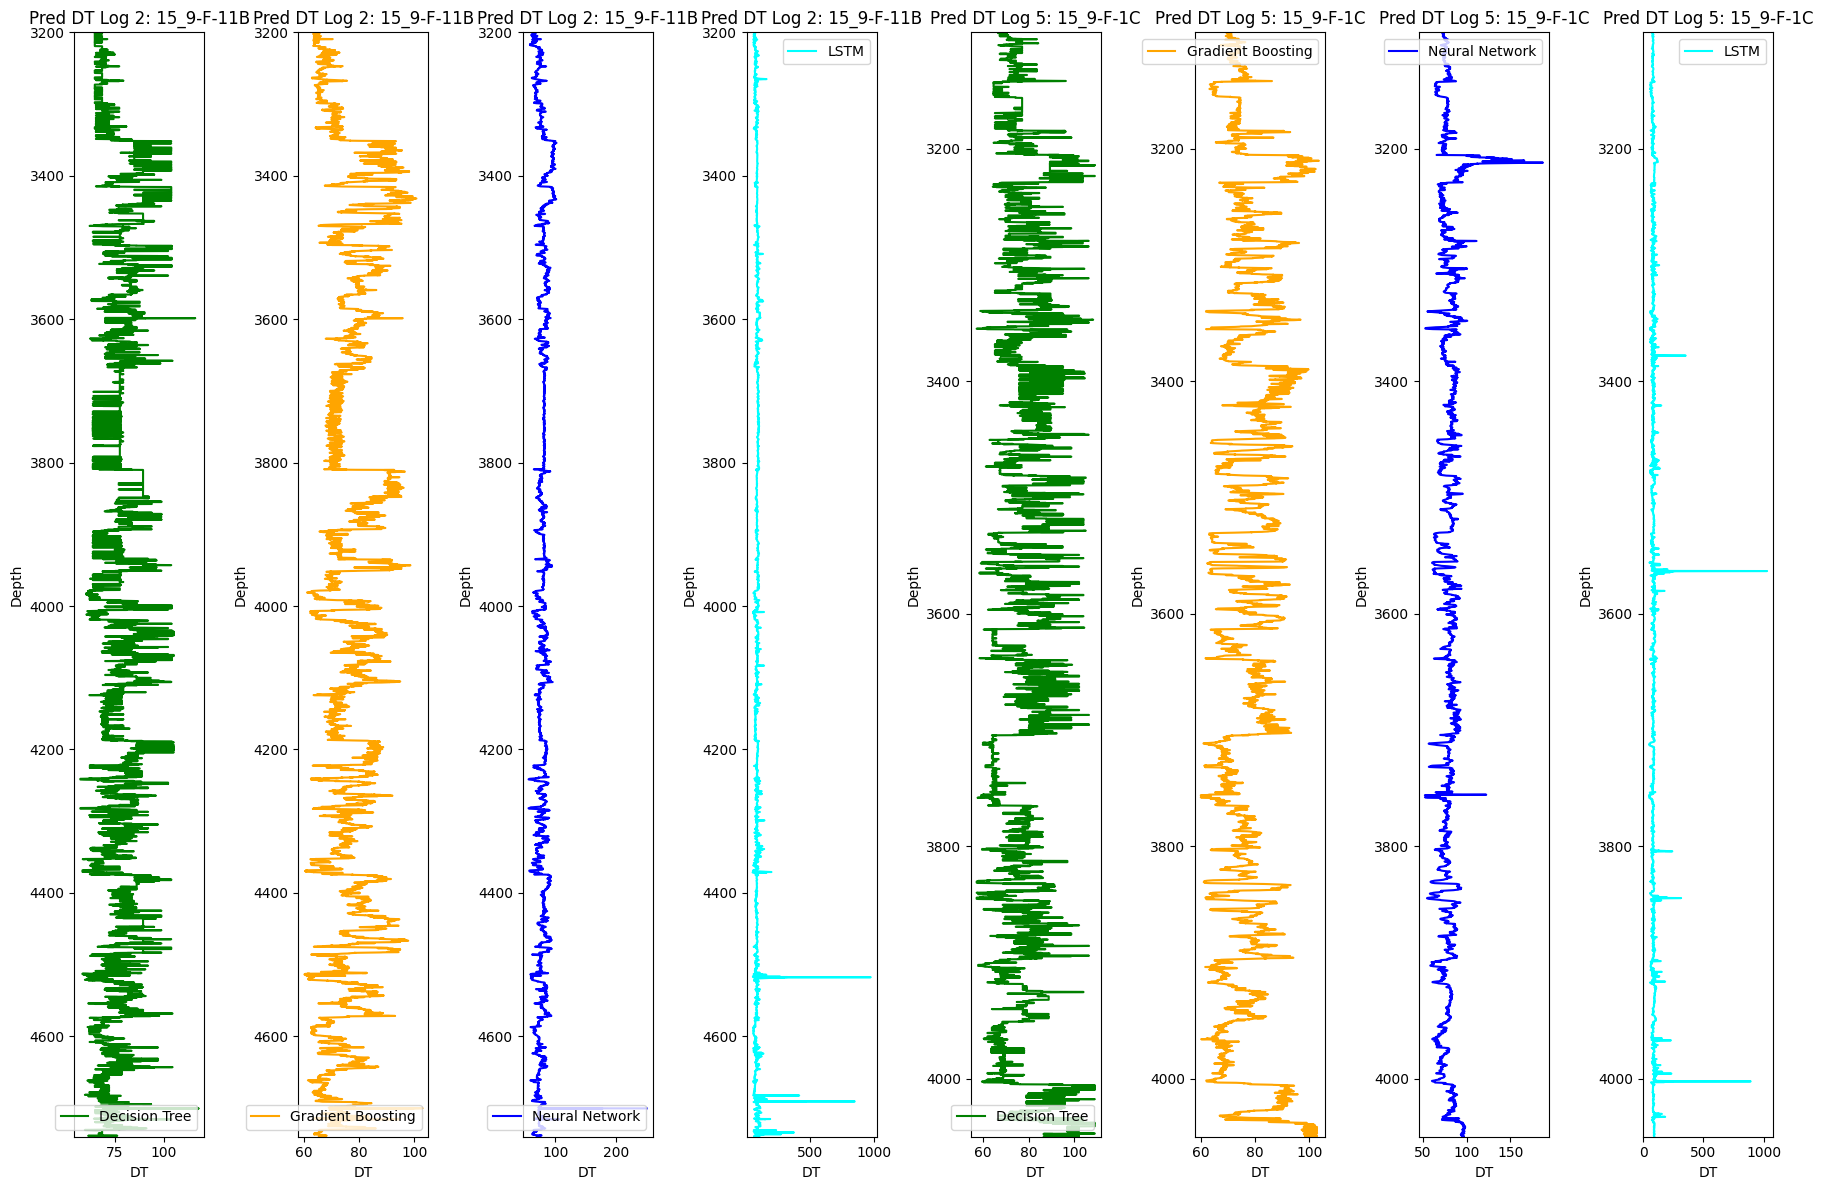

In [54]:
plt.figure(figsize=(18, 12))

# Plot predictions for log 2

plt.subplot(1, 8, 1)
plt.plot(y_pred2_decision_tree, depth2, color='green', label='Decision Tree')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 2)
plt.plot(y_pred2_grad_boost, depth2, color='orange', label='Gradient Boosting')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 3)
plt.plot(y_pred2_nn, depth2, color='blue', label='Neural Network')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 4)
plt.plot(pad_predicted_values(y_pred2_lstm, depth2), depth2, color='cyan', label='LSTM')
plt.ylim(max(depth2), min(depth2))
plt.title('Pred DT Log 2: 15_9-F-11B', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

# For log 5

plt.subplot(1, 8, 5)
plt.plot(y_pred5_decision_tree, depth5, color='green', label='Decision Tree')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 6)
plt.plot(y_pred5_grad_boost, depth5, color='orange', label='Gradient Boosting')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.subplot(1, 8, 7)
plt.plot(y_pred5_nn, depth5, color='blue', label='Neural Network')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()

plt.subplot(1, 8, 8)
plt.plot(pad_predicted_values(y_pred5_lstm, depth5), depth5, color='cyan', label='LSTM')
plt.ylim(max(depth5), min(depth5))
plt.title('Pred DT Log 5: 15_9-F-1C', size=12)
plt.xlabel('DT')
plt.ylabel('Depth')
plt.legend()


plt.tight_layout()
plt.show()


In [55]:
def makeplotpred(df, color_list, suptitle_str="Pass a suptitle"):
    # Column selection from df
    col_names = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'DT_Tree', 'DT_grad_boost', 'DT_nn', 'DT_lstm']
    # Plotting titles
    title = ['NPHI', 'RHOB', 'GR', 'RT', 'PEF', 'CALI', 'Predicted DT Decsion Tree', 'Predicted DT GB', 'Predicted DT NN', 'Predicted DT LSTM']

    # Create the subplots; ncols equals the number of logs
    fig, ax = plt.subplots(nrows=1, ncols=len(col_names), figsize=(20,15))
    fig.suptitle(suptitle_str, size=20, y=1.05)

    # Looping each log to display in the subplots
    for i in range(len(col_names)):
        if i == 3:
            # for resistivity, semilog plot
            ax[i].semilogx(df[col_names[i]], df['DEPTH'], color=color_list[i])

        else:
            # for non-resistivity, normal plot
            ax[i].plot(df[col_names[i]], df['DEPTH'], color=color_list[i])

        ax[i].set_ylim(max(df['DEPTH']), min(df['DEPTH']))
        ax[i].set_title(title[i], pad=15)
        ax[i].grid(True)
        ax[i].legend()

    ax[2].set_xlim(0, 200)
    plt.tight_layout()
    plt.show()

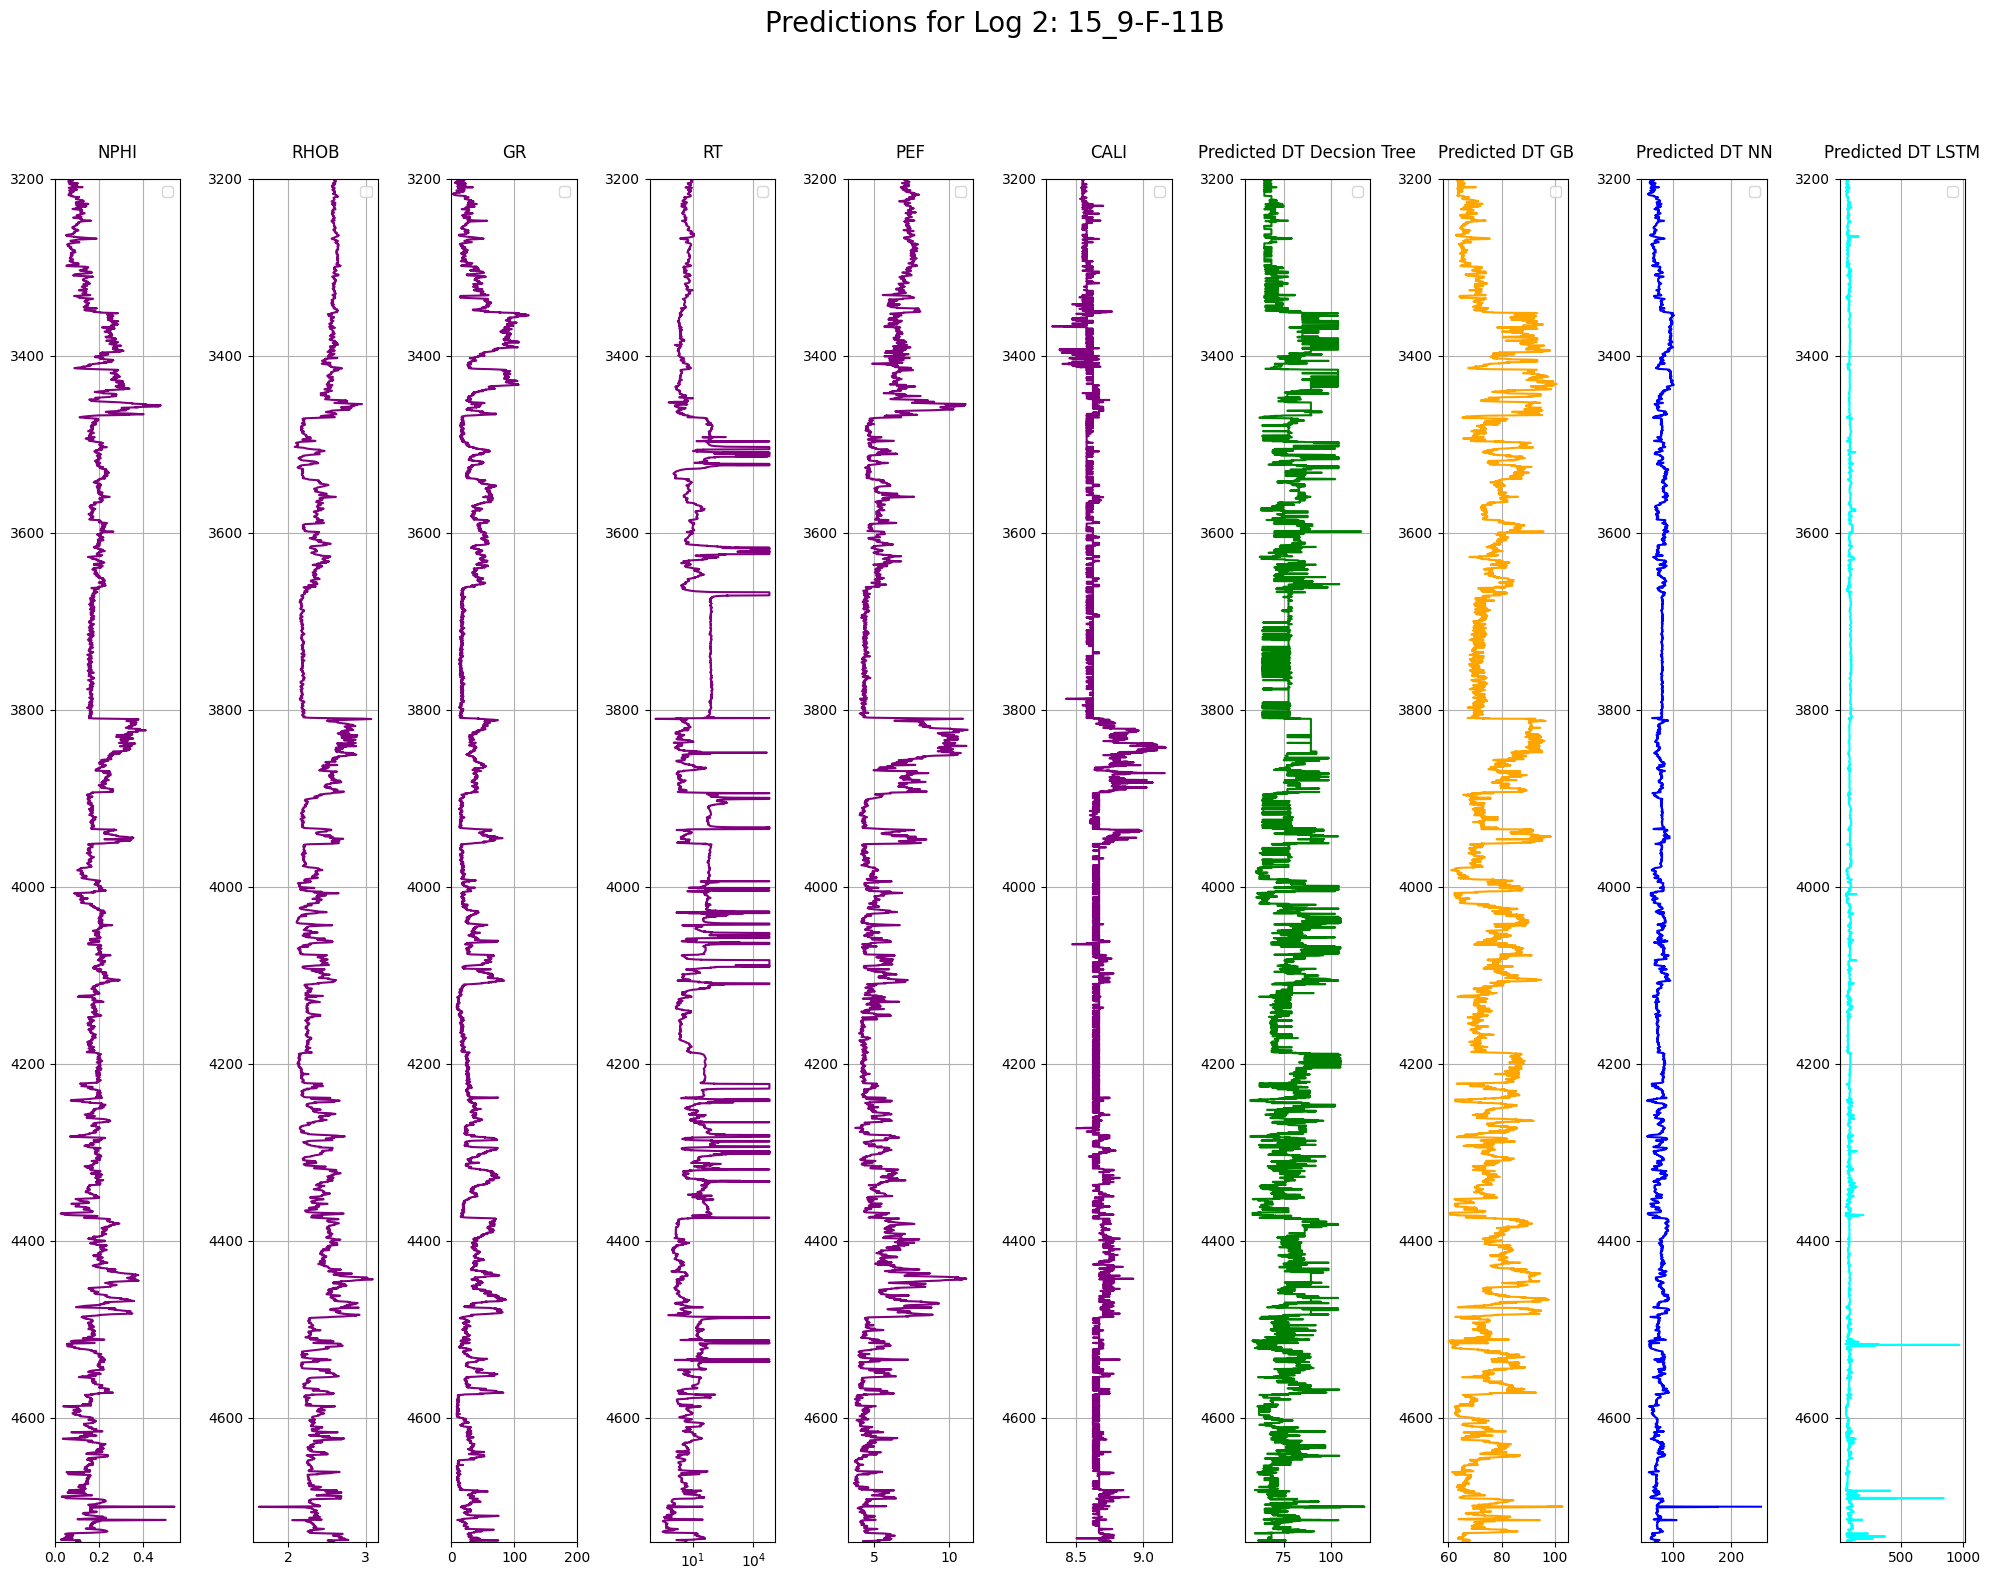

In [56]:
# Assuming `depth` is the depth information shared among all logs
makeplotpred(log2,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 2: 15_9-F-11B")

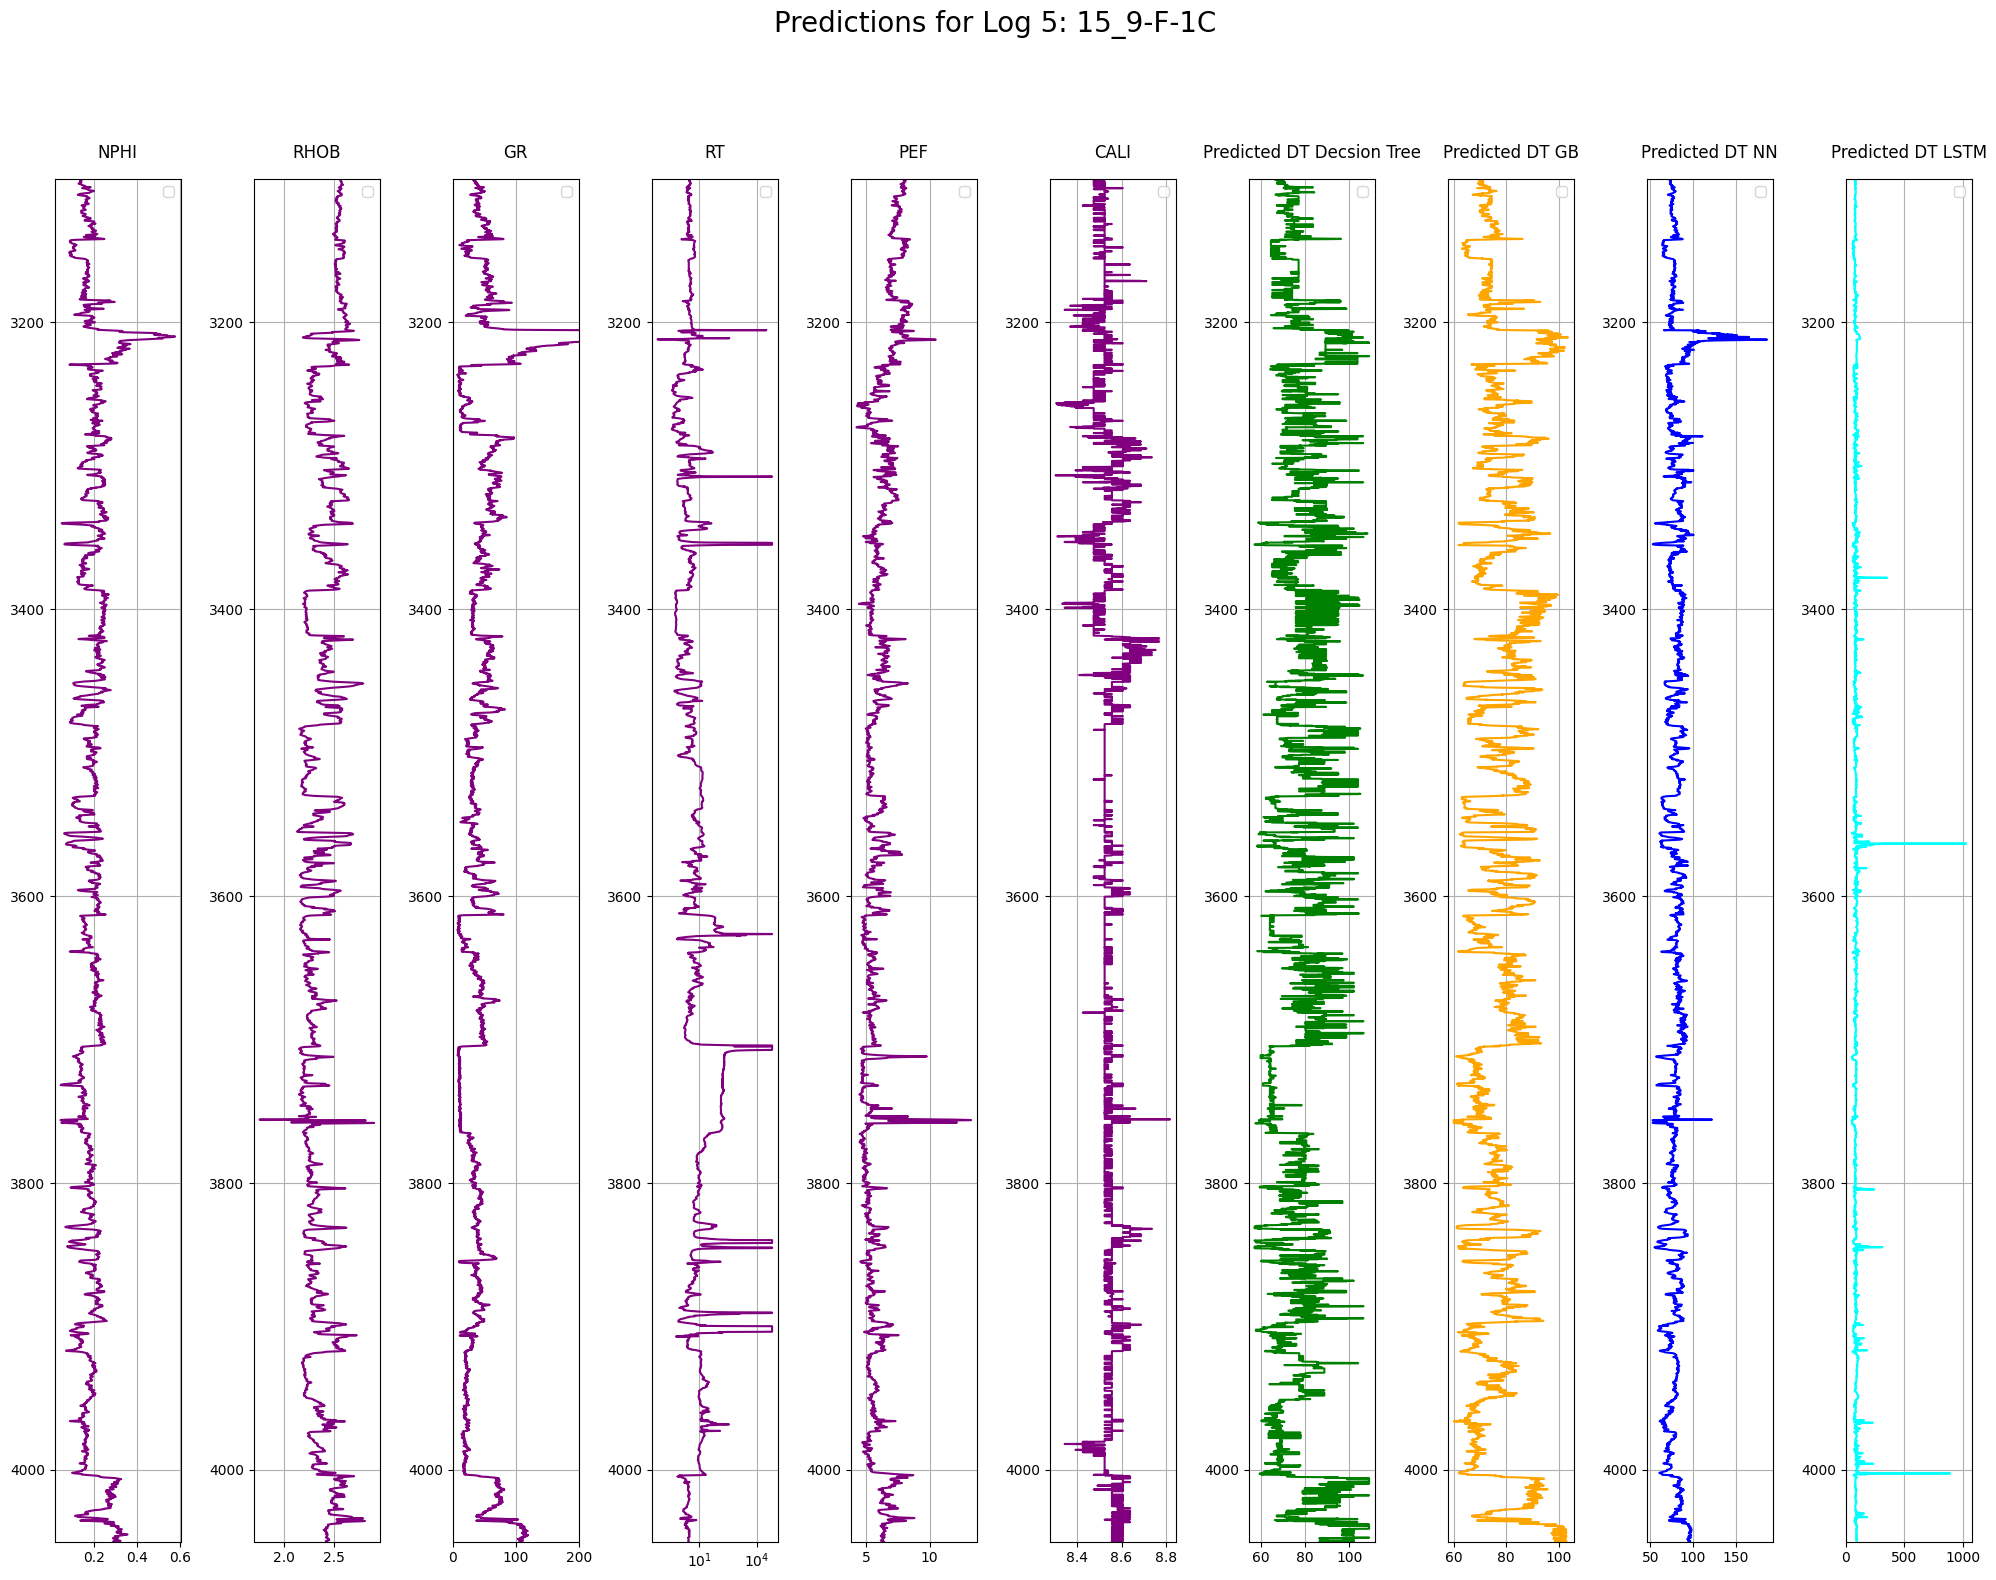

In [57]:
makeplotpred(log5,
             ['purple', 'purple', 'purple', 'purple', 'purple', 'purple', 'green', 'orange', 'blue', 'cyan'],
             suptitle_str="Predictions for Log 5: 15_9-F-1C")